# Drum and Ebony Skin Bleaching Ads

This is a data analysis of skin bleaching ads from Ebony and Drum magazines over several decades. The data was collected by hand and captures several aspects of the ads, including the product, the active ingredient, the claims made, as well as the catch phrases used.

## Table of Contents

* [Data Structure](./#data)
* [Drum Most Frequent Words](./#drum_mfw)
* [Drum Ngrams](#drum_ngram)
* [Ebony Most Frequent Words](./#ebony_mfw)
* [Ebony Ngrams](#ebony_ngram)
* [Term Counts by Year](./#terms_by_year)
* [Parts of Speech](./#pos)

### To do

* compare pos and mfw over time between pubs
* plot ngrams in Drum to request images (ugly, hollywood, husband/bride/marriage)
* send list of 12-15 needed issues and ads

In [1]:
__author__ = "Aaron Mauro"
__role__ = "researcher"
__institution__ = "Brock University"
__email__ = "amauro@brocku.ca"
__status__ = "prototype/experiment"
__version__ = "0.1"

In [2]:
# Imports

import os
import sys
import csv
import string
import itertools
import nltk
import gensim
import pprint as pp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.image as mpimg
import networkx as nx

# direct imports
from gensim import corpora, models
from sklearn.manifold import TSNE
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from IPython.display import SVG, display

# REMOVE IN PROD
import pygal
#pd.set_option('display.mpl_style', 'default')

In [3]:
# Select Matplotlib style
plt.matplotlib.style.use("seaborn")

In [4]:
# English stopwords
STOPS = stopwords.words('english')
print(STOPS)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [5]:
# Add additional stops
new_stops = ["I",] # add new stops here
for stop in new_stops:
    STOPS.append(stop)

<span id="data" class="anchor"></span>
## Data Structure and Sample Contents

In [6]:
# Create dataframe from Ebony skin bleaching adds from 1960-1990

ebony = pd.read_csv("../Ebony.skin.ads.1960-1990.csv", parse_dates=True, index_col='Year')
ebony.head() # show first five rows of dataframe
#ebony.tail() # show last five rows of dataframe

,Region,Source,Product name,chemical/active ingredient,Structure,Chemistry,Claims,Legal issues and Politics,Race,Age,Advertising strategy *quotes-catch phrase*,Size of Advert,Pg reference (quentin marked),Notes
Year,,,,,,,,,,,,,,
1960-01-01,NaN,Ebony,Long Aid Bleach and Glow,unnamed,NaN,NaN,""" - wakes up dark, dull complexion! Conceals u...",NaN,NaN,NaN,NaN,1/2 pg,63,small part of 1.2 pg ad for Long Aid hair prod...
1960-01-01,NaN,NaN,Mercolized Wax Cream,ammoniated mercury; zinc oxide,NaN,NaN,"""If your skin doesn't look actually lighter af...",NaN,NaN,NaN,"""Mercolized Wax Cream guarantees lighter looki...",1/4 pg,72,ingredient on image of product; not mentioned ...
1960-01-01,NaN,NaN,Black and White Bleaching Cream,unnamed,NaN,NaN,"""And you, too, can have a glamorous complexion...",NaN,NaN,NaN,"""Lighter, brighter skin is irresistable""",1/8 pg,83,drawing of white man and white woman in ad
1960-01-01,NaN,NaN,Nadinola Bleaching Cream,"""wonder-working A-M""",NaN,NaN,"""Don't let dull, dark skin rob you of romance....",NaN,NaN,NaN,"""LIFE IS MORE FUN when your complexion is clea...",full pg,91,two types advertised - oily and dry skin
1960-01-01,NaN,NaN,Dr. Fred Palmer's Double Strength Skin Whitener,zinc phenolsulfonate,NaN,NaN,"""Yes in just 7 days be delighted how fast and ...",NaN,NaN,NaN,"""DR. FRED PALMER'S IN JUST 7 DAYS MUST GIVE YO...",1/8 pg,108,NaN


In [7]:
# Create dataframe from Drum skin bleaching adds from 1965-1988

drum = pd.read_csv("../Drum_Skin_Lighteners_1965_1988.csv", parse_dates=True, index_col='Year')
drum.head() # show first five rows of dataframe
# drum.tail() # show last five rows of dataframe

,Product name,chemical/active ingredient,Claims,Legal issues and Politics,Race,Age,Advertising strategy *quotes-catch phrase*,Size of Advert,Pg. reference ( marked),Notes
Year,,,,,,,,,,
1965-01-01,ARTRA skin tone cream,Hydroquinone,…to make their skin lighter and lovelier…lovel...,Black model and white pharmacist/doctor,Black,20+,"Lighter, lovelier skin today…the American way!'",full pg.,pg. 2,The ad says that the cream was developed after...
1965-01-01,NaN,NaN,brightens skin.' '…lightens from the first day...,n/a,NaN,NaN,Cream your skin lighter and brighter with ama...,NaN,pg. 2,Ad states that it is a medicated beauty bar. S...
1965-01-01,NaN,NaN,immediately.' '…keeps skin beautiful and clean...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1965-01-01,Artra beauty bar,Hydroquinone,…mild and gentle…keeps skin free from blemishe...,NaN,NaN,20+,Medicated soap for complexion care,NaN,NaN,NaN
1965-01-01,Aloma Crème blanche,unnamed,"…clears and lightens the skin, smooth's away b...",Black model,Black,20-35,good things happen to a pretty girl,full pg.,NaN,Ad states that using this product will increas...


## Preprocessing Ad Catch Phrases and Claims
As a first step in this analysis, we will capture the most frequent words (MFW) represented in both the catch phrases and claims of the ads. 

In [8]:
# Set the Ebony dataframe index to the year
years_ebony = ebony.index
years_ebony = set(years_ebony.year)

In [9]:
# Set the Drum dataframe index to the year
years_drum = drum.index
years_drum = set(years_drum.year)

In [10]:
# Grab Ebony catch phrases by year and drop rows without data
catch_phrase_ebony = ebony["Advertising strategy *quotes-catch phrase*"].dropna()

In [11]:
# Show first five rows of Ebony catch phrases
catch_phrase_ebony.head()

Year
1960-01-01    "Mercolized Wax Cream guarantees lighter looki...
1960-01-01             "Lighter, brighter skin is irresistable"
1960-01-01    "LIFE IS MORE FUN when your complexion is clea...
1960-01-01    "DR. FRED PALMER'S IN JUST 7 DAYS MUST GIVE YO...
1960-01-01    "Egyptian formula BLEACH CRÈME gives amazing r...
Name: Advertising strategy *quotes-catch phrase*, dtype: object

In [12]:
# Grab Drum catch phrases by year and drop rows without data
catch_phrase_drum = drum["Advertising strategy *quotes-catch phrase*"].dropna()

In [13]:
# Show first five rows of Ebony catch phrases
catch_phrase_drum.head()

Year
1965-01-01      Lighter, lovelier skin today…the American way!'
1965-01-01     Cream your skin lighter and brighter with ama...
1965-01-01                   Medicated soap for complexion care
1965-01-01                  good things happen to a pretty girl
1965-01-01                                            See notes
Name: Advertising strategy *quotes-catch phrase*, dtype: object

In [14]:
# Grab Drum and Ebony claims
claims_ebony = ebony["Claims"].dropna()
claims_drum = drum['Claims'].dropna()
print("Ebony claims",claims_ebony.head())
print(claims_ebony.head())

Ebony claims Year
1960-01-01    " - wakes up dark, dull complexion! Conceals u...
1960-01-01    "If your skin doesn't look actually lighter af...
1960-01-01    "And you, too, can have a glamorous complexion...
1960-01-01    "Don't let dull, dark skin rob you of romance....
1960-01-01    "Yes in just 7 days be delighted how fast and ...
Name: Claims, dtype: object
Year
1960-01-01    " - wakes up dark, dull complexion! Conceals u...
1960-01-01    "If your skin doesn't look actually lighter af...
1960-01-01    "And you, too, can have a glamorous complexion...
1960-01-01    "Don't let dull, dark skin rob you of romance....
1960-01-01    "Yes in just 7 days be delighted how fast and ...
Name: Claims, dtype: object


<span id="drum_mfw" class="anchor"></span>
## Most Frequent Words

In an effort to collect keywords for later processes, we will grab the most frequent words (MFW) and compare them to most common bigram pairs. We'll start with Drum then do the same operations for Ebony.

## Drum Magaine MFW

In [15]:
# Convert dataframe into a list of lists of sentences for Drum
drum_catch_phrase_and_claims = pd.merge(catch_phrase_drum, claims_drum, right_index=True, left_index=True).dropna()
drum_claims_phrase_list = drum_catch_phrase_and_claims.values.tolist()
drum_claims_phrase_list[:10]

[["Lighter, lovelier skin today…the American way!'",
  "…to make their skin lighter and lovelier…lovelier and lighter…a little more every day' '…American scientist made artra…lightens and"],
 ["Lighter, lovelier skin today…the American way!'",
  "brightens skin.' '…lightens from the first day.' '…vanishes into skin instantly…starts working, starts lightening and brightening your skin"],
 ["Lighter, lovelier skin today…the American way!'",
  "immediately.' '…keeps skin beautiful and clean, makes it smooth and lovely"],
 ["Lighter, lovelier skin today…the American way!'",
  '…mild and gentle…keeps skin free from blemishes and pimples'],
 ["Lighter, lovelier skin today…the American way!'",
  "…clears and lightens the skin, smooth's away blemishes and spots, softens the skin'"],
 ["Lighter, lovelier skin today…the American way!'",
  '...gets to work immediately- to give you a lighter, lovelier complexion'],
 ["Lighter, lovelier skin today…the American way!'",
  "a fair complexion, clear sk

In [16]:
# Tokenize and preprocess lists of sentences
drum_word_corpus_list = []
for ad in drum_claims_phrase_list:
    sents = [ch for ch in " ".join(ad).lower() if ch not in string.punctuation+"…"]
    drum_word_corpus_list.append("".join(sents).split())
print(drum_word_corpus_list[:5])

[['lighter', 'lovelier', 'skin', 'todaythe', 'american', 'way', 'to', 'make', 'their', 'skin', 'lighter', 'and', 'lovelierlovelier', 'and', 'lightera', 'little', 'more', 'every', 'day', 'american', 'scientist', 'made', 'artralightens', 'and'], ['lighter', 'lovelier', 'skin', 'todaythe', 'american', 'way', 'brightens', 'skin', 'lightens', 'from', 'the', 'first', 'day', 'vanishes', 'into', 'skin', 'instantlystarts', 'working', 'starts', 'lightening', 'and', 'brightening', 'your', 'skin'], ['lighter', 'lovelier', 'skin', 'todaythe', 'american', 'way', 'immediately', 'keeps', 'skin', 'beautiful', 'and', 'clean', 'makes', 'it', 'smooth', 'and', 'lovely'], ['lighter', 'lovelier', 'skin', 'todaythe', 'american', 'way', 'mild', 'and', 'gentlekeeps', 'skin', 'free', 'from', 'blemishes', 'and', 'pimples'], ['lighter', 'lovelier', 'skin', 'todaythe', 'american', 'way', 'clears', 'and', 'lightens', 'the', 'skin', 'smooths', 'away', 'blemishes', 'and', 'spots', 'softens', 'the', 'skin']]


In [17]:
# Collect all words into single list
drum_word_corpus = []
for sent in drum_word_corpus_list:
    for word in sent:
        drum_word_corpus.append(word)

In [18]:
# Total words in corpus and preview Drum word list 
drum_num = len(drum_word_corpus)
print(f"There are {drum_num:,} words in the Drum Magazine corpus.")
print(drum_word_corpus[:10])

There are 211,112 words in the Drum Magazine corpus.
['lighter', 'lovelier', 'skin', 'todaythe', 'american', 'way', 'to', 'make', 'their', 'skin']


In [19]:
# Create an NLTK Text object
drum_text_object = nltk.Text(drum_word_corpus)

In [20]:
# Generate a sample concordance, displaying 120 characters of 25 matches
drum_text_object.concordance("good",120,25)

Displaying 25 of 428 matches:
e sooner you startexpect a lovely clear bright complexion good things happen to a pretty girl to make their skin lighter
 more every day american scientist made artralightens and good things happen to a pretty girl brightens skin lightens fr
tarts working starts lightening and brightening your skin good things happen to a pretty girl immediately keeps skin bea
keeps skin beautiful and clean makes it smooth and lovely good things happen to a pretty girl mild and gentlekeeps skin 
mild and gentlekeeps skin free from blemishes and pimples good things happen to a pretty girl clears and lightens the sk
he skin smooths away blemishes and spots softens the skin good things happen to a pretty girl gets to work immediately t
ork immediately to give you a lighter lovelier complexion good things happen to a pretty girl a fair complexion clear sk
ish free and spot free can be obtained using this product good things happen to a pretty girl your skin will grow lighte
sh

In [21]:
# Create concordance object as list
drum_concord_list_obj_good = drum_text_object.concordance_list("good")

In [22]:
# Unpack concordance list object into flat list
drum_concord_list_good = []
for con in drum_concord_list_obj_good:
    sent = "".join(list(con[4:]))
    drum_concord_list_good.append(sent)

In [23]:
# Create frequence distribution
drum_concord_list_good_freqs = nltk.FreqDist(drum_concord_list_good)

In [24]:
# Ten most common claims with the word 'good'
drum_concord_list_good_freqs.most_common(10)

[('ur complexion as soon as its used isand works so fast because it containur complexion as soon as its used is good and works so fast because it contain',
  10),
 ('afeno burning or irritation its evenfor painful sunburnt skin karroo morafeno burning or irritation its even good for painful sunburnt skin karroo mor',
  2),
 ('ect a lovely clear bright complexionthings happen to a pretty girl to maect a lovely clear bright complexion good things happen to a pretty girl to ma',
  1),
 ('can scientist made artralightens andthings happen to a pretty girl brighcan scientist made artralightens and good things happen to a pretty girl brigh',
  1),
 ('lightening and brightening your skinthings happen to a pretty girl immedlightening and brightening your skin good things happen to a pretty girl immed',
  1),
 ('and clean makes it smooth and lovelythings happen to a pretty girl mild and clean makes it smooth and lovely good things happen to a pretty girl mild ',
  1),
 ('skin free from blemishes

In [25]:
# Remove stop words
drum_word_corpus_no_stops = []
for word in drum_word_corpus:
    if word not in STOPS: #add extra stops above
        drum_word_corpus_no_stops.append(word)
drum_freqs = nltk.FreqDist(drum_word_corpus_no_stops)
drum_most_common_counts = drum_freqs.most_common(75)
drum_most_common = []
for t,c in drum_most_common_counts:
    drum_most_common.append(t)
pp.pprint(drum_most_common_counts)

[('skin', 11413),
 ('complexion', 3707),
 ('light', 3321),
 ('karroo', 2997),
 ('lighter', 2685),
 ('ambi', 2671),
 ('beautiful', 2646),
 ('lovely', 2262),
 ('beauty', 2006),
 ('makes', 1950),
 ('extra', 1888),
 ('cream', 1826),
 ('use', 1804),
 ('new', 1757),
 ('look', 1701),
 ('smooth', 1669),
 ('lightening', 1650),
 ('fast', 1619),
 ('night', 1594),
 ('lightens', 1534),
 ('keeps', 1532),
 ('clear', 1363),
 ('people', 1332),
 ('smoother', 1173),
 ('pimples', 1149),
 ('spots', 1134),
 ('creams', 1090),
 ('great', 1067),
 ('hollywood', 1048),
 ('day', 992),
 ('blemishes', 977),
 ('looking', 904),
 ('successful', 884),
 ('morning', 881),
 ('dark', 859),
 ('seven', 835),
 ('miss', 805),
 ('acting', 803),
 ('ugly', 787),
 ('best', 778),
 ('lotion', 748),
 ('lighten', 741),
 ('queen', 712),
 ('men', 678),
 ('quick', 676),
 ('super', 658),
 ('lovelier', 655),
 ('time', 639),
 ('treatment', 623),
 ('face', 620),
 ('always', 614),
 ('karoo', 604),
 ('way', 599),
 ('hilite', 595),
 ('clearer',

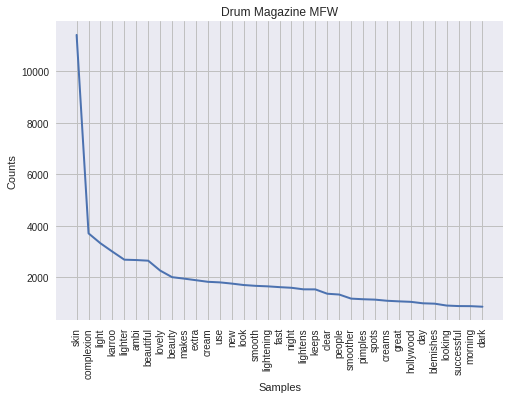

<AxesSubplot:title={'center':'Drum Magazine MFW'}, xlabel='Samples', ylabel='Counts'>

In [26]:
# The most frequent words in Drum Skin Bleaching ads
drum_freqs.plot(35, title="Drum Magazine MFW")

In [27]:
# Looking at the long tail of MFW, people and success are related to lighter skin
# Example concordance
drum_text_object.concordance("people",120,25)

Displaying 25 of 1332 matches:
smoother lighter lovelier skin todaythe american way for people that want a lighter smoother complexion makes skin fair 
our skin lighter and brighter with amazing new artra for people that want a lighter smoother complexion makes skin fair 
arer and smoother medicated soap for complexion care for people that want a lighter smoother complexion makes skin fair 
 extra double strength skin lightening cream for men for people that want a lighter smoother complexion makes skin fair 
 will be clearer and smoother ambi extra always wins for people that want a lighter smoother complexion makes skin fair 
g cream the double strength skin cream for smart men for people that want a lighter smoother complexion makes skin fair 
smoother the best skin lightening cream in the world for people that want a lighter smoother complexion makes skin fair 
ther you too can look as lovely as a beautiful bride for people that want a lighter smoother complexion makes skin fair 
s

In [28]:
# Most common words in context for with keyword 'people'
drum_concord_list_obj = drum_text_object.concordance_list("people", 50)
drum_concord_list = []
for con in drum_concord_list_obj:
    sent = "".join(list(con[4:]))
    drum_concord_list.append(sent)
drum_concord_list_freqs = nltk.FreqDist(drum_concord_list)
drum_concord_list_freqs.most_common(10)

[('ing cream for men forthat want a lighter sing cream for men for people that want a lighter s',
  2),
 ('extra always wins forthat want a lighter sextra always wins for people that want a lighter s',
  2),
 ('eam for smart men forthat want a lighter seam for smart men for people that want a lighter s',
  2),
 ('ream in the world forthat want a lighter sream in the world for people that want a lighter s',
  2),
 ('ythe american way forthat want a lighter sythe american way for people that want a lighter s',
  1),
 ('amazing new artra forthat want a lighter samazing new artra for people that want a lighter s',
  1),
 ('r complexion care forthat want a lighter sr complexion care for people that want a lighter s',
  1),
 ('a beautiful bride forthat want a lighter sa beautiful bride for people that want a lighter s',
  1),
 ('brides complexion forthat want a lighter sbrides complexion for people that want a lighter s',
  1),
 ('n becomes lighter forthat want a lighter sn becomes lighter f

In [29]:
# Success is clearly associated with lighter skin
drum_text_object.concordance("successful", 120, 25)

Displaying 25 of 884 matches:
y makes you light protects skin against harsh sunlight successful people use ambi lighter clearer complexion with ambi a
n give you the smooth clear lighter skin youve notices successful people have successful people use ambi scientifically 
lear lighter skin youve notices successful people have successful people use ambi scientifically formulatedclear the ski
emishes make it smoother and lighter within a few days successful people use ambi absolutely safeno burning or irritatio
 or irritation its even good for painful sunburnt skin successful people use ambi skin looked lighter and smoother prote
and smoother protects your skin against harsh sunlight successful people use ambi worried by little pimples and spotskar
by little pimples and spotskarroo takes these away too successful people use ambi keep my complexion looking light clear
n give you the smooth clear lighter skin youve notices successful people have karroo morning karoo night makes you lovel
n 

In [30]:
# Most common words in context for with keyword 'successful'
drum_concord_list_obj = drum_text_object.concordance_list("successful", 50)
drum_concord_list = []
for con in drum_concord_list_obj:
    sent = "".join(list(con[4:]))
    drum_concord_list.append(sent)
drum_concord_list_freqs = nltk.FreqDist(drum_concord_list)
drum_concord_list_freqs.most_common(10)

[(' skin youve noticespeople have karroo  skin youve notices successful people have karroo ',
  3),
 (' skin youve noticespeople have success skin youve notices successful people have success',
  2),
 ('cessful people havepeople use ambi scicessful people have successful people use ambi sci',
  2),
 ('r within a few dayspeople use ambi absr within a few days successful people use ambi abs',
  2),
 ('inst harsh sunlightpeople use ambi liginst harsh sunlight successful people use ambi lig',
  1),
 ('inful sunburnt skinpeople use ambi skiinful sunburnt skin successful people use ambi ski',
  1),
 ('inst harsh sunlightpeople use ambi worinst harsh sunlight successful people use ambi wor',
  1),
 ('akes these away toopeople use ambi keeakes these away too successful people use ambi kee',
  1),
 (' skin youve noticespeople have perfect skin youve notices successful people have perfect',
  1),
 (' skin youve noticespeople have hilite  skin youve notices successful people have hilite ',
  1)]

In [31]:
drum_text_object.concordance("bride", 120, 25)

Displaying 25 of 80 matches:
ght complexion you too can look as lovely as a beautiful bride to make their skin lighter and lovelierlovelier and ligh
ralightens and you too can look as lovely as a beautiful bride brightens skin lightens from the first day vanishes into
ning your skin you too can look as lovely as a beautiful bride immediately keeps skin beautiful and clean makes it smoo
oth and lovely you too can look as lovely as a beautiful bride mild and gentlekeeps skin free from blemishes and pimple
es and pimples you too can look as lovely as a beautiful bride clears and lightens the skin smooths away blemishes and 
ftens the skin you too can look as lovely as a beautiful bride gets to work immediately to give you a lighter lovelier 
ier complexion you too can look as lovely as a beautiful bride a fair complexion clear skin that is blemish free and sp
g this product you too can look as lovely as a beautiful bride your skin will grow lighter complexion smoother and blem
s of your s

<span id="drum_ngram" class="anchor"></span>

## Bigram and Trigrams in Drum

In [32]:
# Collocations of commonly associated terms in Drum corpus, not necessarily bigrams
# Please see NLTK collocations documentation to understand how collocations are 
# selected: https://www.nltk.org/_modules/nltk/collocations.html

drum_text_object.collocations(num=100)

hollywood seven; karroo morning; successful people; morning karoo;
skin lightening; use ambi; beauty queen; karoo night; karroo creams;
super rose; lighter smoother; people use; lightening cream; modern
way; night makes; arms legs; cosmetic substance; miss south; americas
great; lovely makes; legs neck; always wanted; look great; ugly spots;
powerful name; lighter clearer; face arms; discolouring ugly; fast
acting; german science; extra fast; one step; spots discolouring;
removes ugly; quick acting; thoroughly removes; south africa; neck
removes; acting medicinescleans; given thousands; velvety smooth;
stronger super; double strength; light fantastic; lightening
treatment; new cosmetic; cant lose; rose heman; says miss;
complexionuse full; youll look; removes dark; quicker results; stops
production; new stronger; aviva light; heman lotion; film star; top
society; good looking; ambi youll; great looking; skin lightener;
lighten dark; ugly blemishes; americans lighter; works fast; butter

In [33]:
# Most common bigram frequencies
drum_bigram_list = list(nltk.bigrams(drum_text_object))
drum_bigram_freqs = nltk.FreqDist(drum_bigram_list)
pp.pprint(drum_bigram_freqs.most_common(75))

[(('your', 'skin'), 2664),
 (('makes', 'you'), 1373),
 (('skin', 'lightening'), 1323),
 (('you', 'lovely'), 900),
 (('use', 'ambi'), 896),
 (('you', 'light'), 887),
 (('karroo', 'morning'), 881),
 (('hollywood', 'seven'), 807),
 (('karroo', 'creams'), 741),
 (('successful', 'people'), 684),
 (('a', 'lighter'), 674),
 (('lighter', 'smoother'), 634),
 (('beauty', 'queen'), 627),
 (('lightening', 'cream'), 621),
 (('beautiful', 'skin'), 620),
 (('night', 'makes'), 616),
 (('lovely', 'makes'), 616),
 (('spots', 'and'), 610),
 (('people', 'use'), 590),
 (('pimples', 'and'), 590),
 (('morning', 'karoo'), 564),
 (('karoo', 'night'), 564),
 (('can', 'have'), 563),
 (('for', 'a'), 555),
 (('in', 'the'), 535),
 (('keeps', 'you'), 530),
 (('smooth', 'and'), 513),
 (('the', 'best'), 500),
 (('and', 'pimples'), 484),
 (('extra', 'fast'), 480),
 (('look', 'great'), 476),
 (('while', 'it'), 465),
 (('keeps', 'skin'), 437),
 (('more', 'beautiful'), 426),
 (('light', 'skin'), 419),
 (('super', 'rose'),

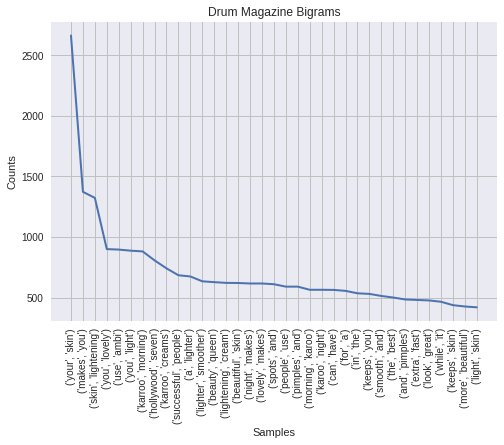

<AxesSubplot:title={'center':'Drum Magazine Bigrams'}, xlabel='Samples', ylabel='Counts'>

In [34]:
drum_bigram_freqs.plot(35, title="Drum Magazine Bigrams")

In [35]:
# Drum trigram frequencies
# Notice the most frequent trigrams relate to "makes you" construction. The sense that skin
# bleaching is about self-making and identity formation. There is a relationship between skin 
# colour and the American mythology of self-made success.
drum_trigram_list = list(nltk.trigrams(drum_text_object))
drum_trigram_freqs = nltk.FreqDist(drum_trigram_list)
pp.pprint(drum_trigram_freqs.most_common(75))

[(('night', 'makes', 'you'), 616),
 (('makes', 'you', 'lovely'), 616),
 (('you', 'lovely', 'makes'), 616),
 (('lovely', 'makes', 'you'), 616),
 (('makes', 'you', 'light'), 616),
 (('karroo', 'morning', 'karoo'), 564),
 (('morning', 'karoo', 'night'), 564),
 (('skin', 'lightening', 'cream'), 544),
 (('successful', 'people', 'use'), 427),
 (('spots', 'and', 'pimples'), 425),
 (('people', 'use', 'ambi'), 393),
 (('while', 'it', 'lightens'), 385),
 (('ugly', 'spots', 'and'), 375),
 (('the', 'modern', 'way'), 349),
 (('lighten', 'your', 'skin'), 340),
 (('you', 'can', 'have'), 339),
 (('now', 'you', 'can'), 335),
 (('your', 'skin', 'the'), 330),
 (('karroo', 'morning', 'karroo'), 317),
 (('morning', 'karroo', 'at'), 317),
 (('karroo', 'at', 'night'), 317),
 (('at', 'night', 'makes'), 317),
 (('skin', 'lightening', 'treatment'), 314),
 (('pimples', 'and', 'blemishes'), 313),
 (('a', 'beauty', 'queen'), 301),
 (('for', 'a', 'lighter'), 300),
 (('karoo', 'night', 'makes'), 299),
 (('lovely', '

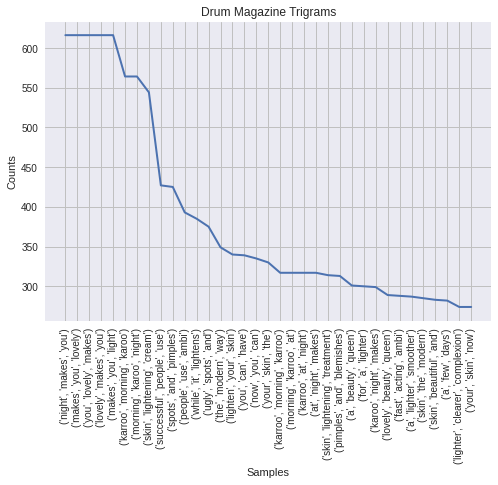

<AxesSubplot:title={'center':'Drum Magazine Trigrams'}, xlabel='Samples', ylabel='Counts'>

In [36]:
# A plot of Drum Magazine trigrams
drum_trigram_freqs.plot(35, title="Drum Magazine Trigrams")

In [37]:
# While the quadgrams continue with the "makes you" construction, later formations introduce
# the logic of possibility in the present. The "now you can" phrasing figures prominently in ads
# which highlights the urgency of attaining associated attributes like whiteness, beauty,
# modernity, and success. 
drum_quadgram_list = list(nltk.ngrams(drum_text_object, 4))
drum_quadgram_freqs = nltk.FreqDist(drum_quadgram_list)
pp.pprint(drum_quadgram_freqs.most_common(75))

[(('night', 'makes', 'you', 'lovely'), 616),
 (('makes', 'you', 'lovely', 'makes'), 616),
 (('you', 'lovely', 'makes', 'you'), 616),
 (('lovely', 'makes', 'you', 'light'), 616),
 (('karroo', 'morning', 'karoo', 'night'), 564),
 (('successful', 'people', 'use', 'ambi'), 393),
 (('ugly', 'spots', 'and', 'pimples'), 323),
 (('karroo', 'morning', 'karroo', 'at'), 317),
 (('morning', 'karroo', 'at', 'night'), 317),
 (('karroo', 'at', 'night', 'makes'), 317),
 (('at', 'night', 'makes', 'you'), 317),
 (('morning', 'karoo', 'night', 'makes'), 299),
 (('karoo', 'night', 'makes', 'you'), 299),
 (('your', 'skin', 'the', 'modern'), 285),
 (('skin', 'the', 'modern', 'way'), 285),
 (('white', 'skin', 'whitens', 'your'), 273),
 (('skin', 'whitens', 'your', 'skin'), 273),
 (('whitens', 'your', 'skin', 'now'), 273),
 (('your', 'skin', 'now', 'you'), 273),
 (('skin', 'now', 'you', 'can'), 273),
 (('now', 'you', 'can', 'have'), 273),
 (('you', 'can', 'have', 'the'), 273),
 (('can', 'have', 'the', 'beauti

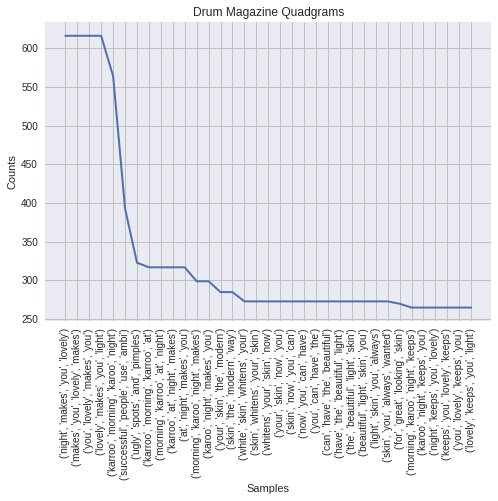

<AxesSubplot:title={'center':'Drum Magazine Quadgrams'}, xlabel='Samples', ylabel='Counts'>

In [38]:
# A plot of Drum Magazine quadgrams
drum_quadgram_freqs.plot(35, title="Drum Magazine Quadgrams")

<span id="ebony_mfw" class="anchor"></span>

## Ebony Magazine MFW 

In [39]:
# Convert dataframe into a list of lists of sentences for Ebony
ebony_catch_phrase_and_claims = pd.merge(catch_phrase_ebony, claims_ebony, right_index=True, left_index=True).dropna()
ebony_claims_phrase_list = ebony_catch_phrase_and_claims.values.tolist()
ebony_claims_phrase_list[:10]

[['"Mercolized Wax Cream guarantees lighter looking skin in just 7 days or money back!"',
  '" - wakes up dark, dull complexion! Conceals ugly blotches, blemishes while it bleaches. Guarantees lovelier, lighter skin."'],
 ['"Mercolized Wax Cream guarantees lighter looking skin in just 7 days or money back!"',
  '"If your skin doesn\'t look actually lighter after using Mercolized Wax Cream for just one week, your money will be cheerfully refunded."; "You\'ll see amazing results almost at once - as Mercolized Wax Cream\'s speedy bleaching action lightens your complexion, fades dark blotches, spots, and freckles, brings excessive skin oiliness under control."; "...works under the skin surface to bring about these marvelous results."; "Used by beautiful women for over 40 years."'],
 ['"Mercolized Wax Cream guarantees lighter looking skin in just 7 days or money back!"',
  '"And you, too, can have a glamorous complexion!"; "…see your skin get a lighter, brighter, softer look."; "Its bleachi

In [40]:
# Tokenize and preprocess lists of sentences
ebony_word_corpus_list = []
for ad in ebony_claims_phrase_list:
    sents = [ch for ch in " ".join(ad).lower() if ch not in string.punctuation+"…"]
    ebony_word_corpus_list.append("".join(sents).split())
print(ebony_word_corpus_list[:5])            

[['mercolized', 'wax', 'cream', 'guarantees', 'lighter', 'looking', 'skin', 'in', 'just', '7', 'days', 'or', 'money', 'back', 'wakes', 'up', 'dark', 'dull', 'complexion', 'conceals', 'ugly', 'blotches', 'blemishes', 'while', 'it', 'bleaches', 'guarantees', 'lovelier', 'lighter', 'skin'], ['mercolized', 'wax', 'cream', 'guarantees', 'lighter', 'looking', 'skin', 'in', 'just', '7', 'days', 'or', 'money', 'back', 'if', 'your', 'skin', 'doesnt', 'look', 'actually', 'lighter', 'after', 'using', 'mercolized', 'wax', 'cream', 'for', 'just', 'one', 'week', 'your', 'money', 'will', 'be', 'cheerfully', 'refunded', 'youll', 'see', 'amazing', 'results', 'almost', 'at', 'once', 'as', 'mercolized', 'wax', 'creams', 'speedy', 'bleaching', 'action', 'lightens', 'your', 'complexion', 'fades', 'dark', 'blotches', 'spots', 'and', 'freckles', 'brings', 'excessive', 'skin', 'oiliness', 'under', 'control', 'works', 'under', 'the', 'skin', 'surface', 'to', 'bring', 'about', 'these', 'marvelous', 'results', '

In [41]:
# Collect all words into single sentence
ebony_word_corpus = []
for sent in ebony_word_corpus_list:
    for word in sent:
        ebony_word_corpus.append(word)

In [42]:
# Total words in corpus and preview Drum word list 
ebony_num = len(ebony_word_corpus)
print(f"There are {ebony_num:,} words in the Ebony Magazine corpus. Remember, Drum Magazine contained {drum_num:,} words.")
print(ebony_word_corpus[:10])

There are 632,675 words in the Ebony Magazine corpus. Remember, Drum Magazine contained 211,112 words.
['mercolized', 'wax', 'cream', 'guarantees', 'lighter', 'looking', 'skin', 'in', 'just', '7']


In [43]:
# Create an NLTK Text object
ebony_text_object = nltk.Text(ebony_word_corpus)

In [44]:
# Generate a sample concordance, displaying 120 characters of 25 matches
ebony_text_object.concordance("good",120,25)

Displaying 25 of 205 matches:
ghten glorify skin or money back i am excited about a new good looks cream for the whole family with gentle laboratory t
 radiance of that artra look now i am excited about a new good looks cream for the whole family that velvetysoft radiant
ient proven safe for normal skin i am excited about a new good looks cream for the whole family now at last a complexion
 thats lighter brighter lovelier i am excited about a new good looks cream for the whole family long for the radiant glo
skin artra softens your skin too i am excited about a new good looks cream for the whole family no more messy oldfashion
leaching ingredient hydroquinone i am excited about a new good looks cream for the whole family clothes do the most for 
of no faster way to lighten skin i am excited about a new good looks cream for the whole family photo caption now one ac
learer smooth and radiantly soft i am excited about a new good looks cream for the whole family a delightful white cream
ig

In [45]:
# Most common words in context for with keyword 'good'
drum_concord_list_obj = drum_text_object.concordance_list("good", 50)
drum_concord_list = []
for con in drum_concord_list_obj:
    sent = "".join(list(con[4:]))
    drum_concord_list.append(sent)
drum_concord_list_freqs = nltk.FreqDist(drum_concord_list)
drum_concord_list_freqs.most_common(10)

[('as soon as its used isand works so fast becaas soon as its used is good and works so fast beca',
  10),
 ('or irritation its evenfor painful sunburnt sor irritation its even good for painful sunburnt s',
  4),
 ('lear bright complexionthings happen to a prelear bright complexion good things happen to a pre',
  1),
 ('made artralightens andthings happen to a premade artralightens and good things happen to a pre',
  1),
 (' brightening your skinthings happen to a pre brightening your skin good things happen to a pre',
  1),
 ('s it smooth and lovelythings happen to a pres it smooth and lovely good things happen to a pre',
  1),
 (' blemishes and pimplesthings happen to a pre blemishes and pimples good things happen to a pre',
  1),
 ('spots softens the skinthings happen to a prespots softens the skin good things happen to a pre',
  1),
 ('er lovelier complexionthings happen to a preer lovelier complexion good things happen to a pre',
  1),
 ('ned using this productthings happen to a p

In [46]:
# Most common words in Ebony skin bleaching ads
# Remove stop words
ebony_word_corpus_no_stops = []
for word in ebony_word_corpus:
    if word not in STOPS: #add extra stops above
        ebony_word_corpus_no_stops.append(word)
ebony_freqs = nltk.FreqDist(ebony_word_corpus_no_stops)
ebony_most_common_counts = ebony_freqs.most_common(75)
ebony_most_common = []
for t,c in ebony_most_common_counts:
    ebony_most_common.append(t)
pp.pprint(ebony_most_common_counts)

[('skin', 26920),
 ('cream', 8765),
 ('complexion', 5046),
 ('lighter', 4923),
 ('new', 4350),
 ('beauty', 4060),
 ('nadinola', 3785),
 ('dark', 3515),
 ('artra', 3448),
 ('use', 3307),
 ('look', 3242),
 ('glow', 3139),
 ('spots', 2922),
 ('brighter', 2896),
 ('tone', 2557),
 ('blackheads', 2432),
 ('bleach', 2402),
 ('bleaching', 2395),
 ('face', 2375),
 ('see', 2321),
 ('helps', 2309),
 ('clear', 2255),
 ('lovelier', 2177),
 ('blemishes', 2135),
 ('works', 2080),
 ('contains', 1974),
 ('smooth', 1908),
 ('even', 1835),
 ('action', 1767),
 ('away', 1757),
 ('effective', 1744),
 ('treatment', 1733),
 ('ultra', 1673),
 ('ingredient', 1667),
 ('smoother', 1655),
 ('clearer', 1645),
 ('pores', 1642),
 ('women', 1590),
 ('fade', 1578),
 ('formula', 1508),
 ('try', 1501),
 ('beautiful', 1497),
 ('esoterica', 1492),
 ('care', 1491),
 ('ambi', 1475),
 ('one', 1461),
 ('soft', 1424),
 ('help', 1404),
 ('results', 1336),
 ('hydroquinone', 1321),
 ('day', 1321),
 ('surface', 1317),
 ('special', 

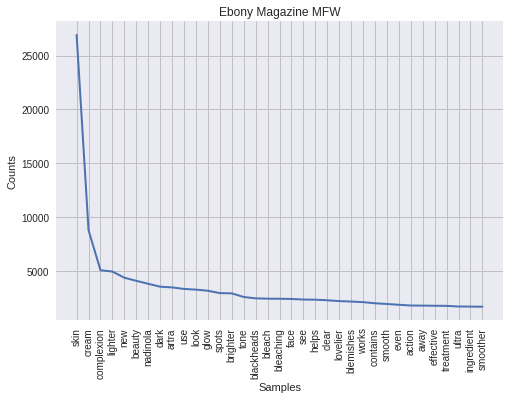

<AxesSubplot:title={'center':'Ebony Magazine MFW'}, xlabel='Samples', ylabel='Counts'>

In [47]:
# A plot of Ebony Magazine MFW
ebony_freqs.plot(35, title="Ebony Magazine MFW")

In [48]:
# Skin bleaching products are associated with newness, like many consumer products
# The new "feeling" is about "discovery," almost as if skin bleaching is about excavating
# a new, lighter sense of self. 
ebony_text_object.concordance("new",120,50)

Displaying 50 of 4350 matches:
 your complexion lovelier and keep it that way so enjoy a new feeling of distinction and beauty convinceyourself of the
 your complexion lovelier and keep it that way so enjoy a new feeling of distinction and beauty convinceyourself of the
 your complexion lovelier and keep it that way so enjoy a new feeling of distinction and beauty convinceyourself of the
 your complexion lovelier and keep it that way so enjoy a new feeling of distinction and beauty convinceyourself of the
 your complexion lovelier and keep it that way so enjoy a new feeling of distinction and beauty convinceyourself of the
 lighter lovelier skin thats both thorough and gentle its new artra skin tone cream with hydroquinone the miracleaction
ep skin clear and clean biggest beauty value you ever saw new bleach and glow leaves your skin shades lighter clearer s
rsened areas clears blemishes blackheads too now in handy new plastic squeeze tube fits perfectly into purse or makeup 
auty valu

In [49]:
# Most common words in context for with keyword 'new'
ebony_concord_list_obj = ebony_text_object.concordance_list("new", 50)
ebony_concord_list = []
for con in ebony_concord_list_obj:
    sent = "".join(list(con[4:]))
    ebony_concord_list.append(sent)
ebony_concord_list_freqs = nltk.FreqDist(ebony_concord_list)
ebony_concord_list_freqs.most_common(10)

[('it that way so enjoy afeeling of distinctionit that way so enjoy a new feeling of distinction',
  5),
 ('nder of modern scienceartra skin tone cream nder of modern science new artra skin tone cream ',
  5),
 ('horough and gentle itsartra skin tone cream horough and gentle its new artra skin tone cream ',
  4),
 ('heads too now in handyplastic squeeze tube fheads too now in handy new plastic squeeze tube f',
  4),
 ('ll dark skin take on alighter brighter softell dark skin take on a new lighter brighter softe',
  3),
 ('uty value you ever sawbleach and glow leavesuty value you ever saw new bleach and glow leaves',
  1),
 ('nds of satisfied usersbleach and glow leavesnds of satisfied users new bleach and glow leaves',
  1),
 ('ok of total lovelinessbleach and glow leavesok of total loveliness new bleach and glow leaves',
  1),
 ('t 7 days or money backbleach and glow leavest 7 days or money back new bleach and glow leaves',
  1)]

In [50]:
# The discovery of new products and formulas is aligned with the discovery of beauty, 
# and even a community of other men and women using these products. 
ebony_text_object.concordance("discover",120,230)

Displaying 230 of 230 matches:
he lightest loveliest exciting skin of your life try it discover for yourself how soft light and radiant your skin can b
he lightest loveliest exciting skin of your life try it discover for yourself how soft light and radiant your skin can b
he lightest loveliest exciting skin of your life try it discover for yourself how soft light and radiant your skin can b
he lightest loveliest exciting skin of your life try it discover for yourself how soft light and radiant your skin can b
he lightest loveliest exciting skin of your life try it discover for yourself how soft light and radiant your skin can b
he lightest loveliest exciting skin of your life try it discover for yourself how soft light and radiant your skin can b
he lightest loveliest exciting skin of your life try it discover for yourself how soft light and radiant your skin can b
he lightest loveliest exciting skin of your life try it discover for yourself how soft light and radiant your skin can b
h

In [51]:
# Most common words in context for with keyword 'discover'. In this case, there is only one
# slogan that repeats in the corpus, but it repeats 25 times so it appears in many ads.
ebony_concord_list_obj = ebony_text_object.concordance_list("discover", 70)
ebony_concord_list = []
for con in ebony_concord_list_obj:
    sent = "".join(list(con[4:]))
    ebony_concord_list.append(sent)
ebony_concord_list_freqs = nltk.FreqDist(ebony_concord_list)
ebony_concord_list_freqs.most_common(10)

[('iting skin of your life try itfor yourself how soft light aniting skin of your life try it discover for yourself how soft light an',
  25)]

<span id="ebony_ngram" class="anchor"></span>

## Bigram and Trigrams in Ebony

In [52]:
# Collocations of commonly associated terms in Ebony corpus, not necessarily bigrams
# Please see NLTK collocations documentation to understand how collocations are 
# selected: https://www.nltk.org/_modules/nltk/collocations.html

ebony_text_object.collocations(num=100)

lighter brighter; mercolized wax; bleaching cream; skin tone; fred
palmers; money back; enlarged pores; ultra nadinola; ammoniated
mercury; dark spots; tone cream; nadinola deluxe; modern science;
basenot greasyvanishes; greasyvanishes immediatelyfor; externally
caused; laboratories inc; inc trademark; drake laboratories; dont let;
million times; powder basenot; smootha powder; peeling treatment;
times everyone; white bleaching; persulan proved; wax cream;
repeatedly prescribed; start using; everyone knows; skin whitener;
makeup base; bleaching action; exclusive formula; palmers skin;
ingredients repeatedly; refining enlarged; ponds vanishing;
hydroquinone compounds; stabilized hydroquinone; brown spots; eye
shadows; dry blotchy; young people; helps keep; razor bumps; gplus
action; persu persu; care enough; vanishing cream; large pores;
cheerfully refunded; bright nadinolalight; peelerpak treatment; dull
dark; medicated ingredient; use persulan; highly recommended;
consecutive nights; 

In [53]:
# Most common bigram frequencies in Ebony Magazine. It is notable that Dr. Fred Palmer's
# skin cream is still manufactured in the US: 
# https://summitlabsinc.com/product/dr-fred-summit-skin-whitener-tone-and-bleach-cream/
ebony_bigram_list = list(nltk.bigrams(ebony_text_object))
ebony_bigram_freqs = nltk.FreqDist(ebony_bigram_list)
pp.pprint(ebony_bigram_freqs.most_common(75))

[(('your', 'skin'), 6006),
 (('lighter', 'brighter'), 1916),
 (('skin', 'tone'), 1881),
 (('bleach', 'and'), 1735),
 (('and', 'glow'), 1616),
 (('bleaching', 'cream'), 1416),
 (('a', 'lighter'), 1210),
 (('tone', 'cream'), 1185),
 (('your', 'complexion'), 1160),
 (('the', 'skin'), 1123),
 (('blackheads', 'and'), 1034),
 (('dark', 'spots'), 1012),
 (('mercolized', 'wax'), 996),
 (('will', 'be'), 996),
 (('of', 'your'), 962),
 (('palmers', 'skin'), 941),
 (('your', 'face'), 932),
 (('spots', 'and'), 919),
 (('ultra', 'nadinola'), 914),
 (('as', 'a'), 859),
 (('skin', 'whitener'), 853),
 (('artra', 'skin'), 825),
 (('for', 'a'), 810),
 (('to', 'use'), 798),
 (('glow', 'cream'), 780),
 (('black', 'and'), 775),
 (('and', 'white'), 775),
 (('wax', 'cream'), 771),
 (('in', 'the'), 771),
 (('skin', 'to'), 764),
 (('skin', 'beauty'), 761),
 (('nadinola', 'deluxe'), 751),
 (('can', 'be'), 741),
 (('as', 'it'), 722),
 (('brighter', 'skin'), 721),
 (('dr', 'fred'), 689),
 (('on', 'the'), 681),
 ((

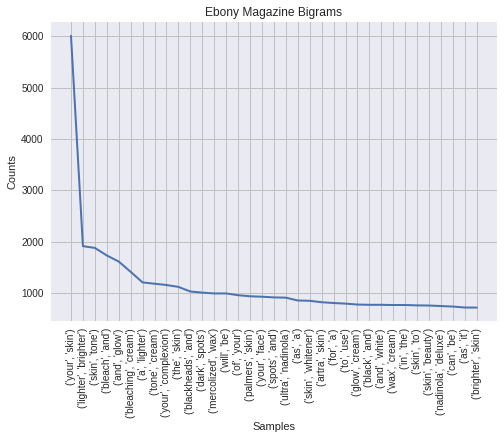

<AxesSubplot:title={'center':'Ebony Magazine Bigrams'}, xlabel='Samples', ylabel='Counts'>

In [54]:
# A plot of Ebony bigrams
ebony_bigram_freqs.plot(35, title="Ebony Magazine Bigrams")

In [55]:
# Ebony trigram frequencies exposes a distinct phrasing from Drum ads, with assurances about 
# effectiveness and provenness of the product. Perhaps there is more skepticism to use of these
# products and the need to assure that 20 million people have used these is products might
# give confidence to otherwise suspicious products. The presence of the "normal skin" construction
# is perhaps the most leading phrasing here. 
ebony_trigram_list = list(nltk.trigrams(ebony_text_object))
ebony_trigram_freqs = nltk.FreqDist(ebony_trigram_list)
pp.pprint(ebony_trigram_freqs.most_common(75))

[(('bleach', 'and', 'glow'), 1583),
 (('skin', 'tone', 'cream'), 1118),
 (('black', 'and', 'white'), 775),
 (('mercolized', 'wax', 'cream'), 771),
 (('and', 'glow', 'cream'), 741),
 (('artra', 'skin', 'tone'), 726),
 (('over', '40', 'years'), 674),
 (('dr', 'fred', 'palmers'), 665),
 (('lighter', 'brighter', 'skin'), 645),
 (('and', 'white', 'bleaching'), 623),
 (('white', 'bleaching', 'cream'), 610),
 (('palmers', 'skin', 'whitener'), 573),
 (('fred', 'palmers', 'skin'), 552),
 (('for', 'over', '40'), 536),
 (('a', 'lighter', 'brighter'), 516),
 (('contains', 'the', 'new'), 511),
 (('to', 'use', 'the'), 478),
 (('helps', 'keep', 'skin'), 473),
 (('nadinola', 'bleaching', 'cream'), 461),
 (('and', 'see', 'your'), 425),
 (('by', 'doctors', 'for'), 422),
 (('bleaching', 'cream', 'as'), 421),
 (('cream', 'as', 'directed'), 421),
 (('for', 'normal', 'skin'), 421),
 (('skin', 'soft', 'and'), 414),
 (('bleaching', 'action', 'works'), 411),
 (('dry', 'blotchy', 'skin'), 400),
 (('the', 'world

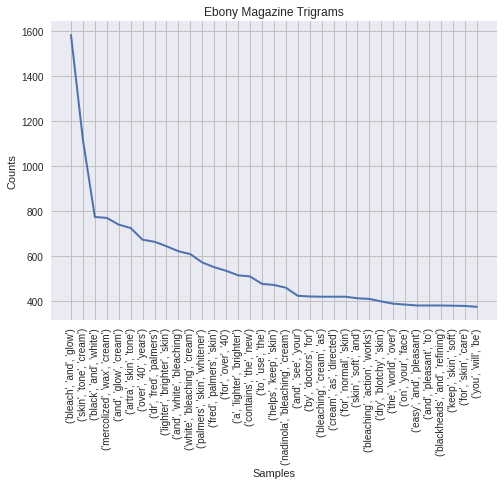

<AxesSubplot:title={'center':'Ebony Magazine Trigrams'}, xlabel='Samples', ylabel='Counts'>

In [56]:
# A plot of trigrams in Ebony Magazine
ebony_trigram_freqs.plot(35, title="Ebony Magazine Trigrams")

In [57]:
# Quaddgrams for Ebony Magazine emphasize the "finest" skin and "ingredients." The presence of 
# scientific words of assurance like "laboratories," "doctors," and "prescribed" suggests these
# ads are seeking scientific legitimacy. The most explicit alignment of these ideas coming together
# in the ('your', 'skin', 'modern', 'science') quadgram.
ebony_quadgram_list = list(nltk.ngrams(ebony_text_object, 4))
ebony_quadgram_freqs = nltk.FreqDist(ebony_quadgram_list)
pp.pprint(ebony_quadgram_freqs.most_common(75))

[(('artra', 'skin', 'tone', 'cream'), 726),
 (('bleach', 'and', 'glow', 'cream'), 710),
 (('black', 'and', 'white', 'bleaching'), 623),
 (('and', 'white', 'bleaching', 'cream'), 610),
 (('dr', 'fred', 'palmers', 'skin'), 552),
 (('fred', 'palmers', 'skin', 'whitener'), 544),
 (('for', 'over', '40', 'years'), 536),
 (('white', 'bleaching', 'cream', 'as'), 421),
 (('bleaching', 'cream', 'as', 'directed'), 421),
 (('easy', 'and', 'pleasant', 'to'), 382),
 (('use', 'persulan', 'proved', 'more'), 375),
 (('persulan', 'proved', 'more', 'than'), 375),
 (('proved', 'more', 'than', '20'), 375),
 (('more', 'than', '20', 'million'), 375),
 (('than', '20', 'million', 'times'), 375),
 (('20', 'million', 'times', 'everyone'), 375),
 (('million', 'times', 'everyone', 'knows'), 375),
 (('times', 'everyone', 'knows', 'you'), 375),
 (('everyone', 'knows', 'you', 'care'), 375),
 (('knows', 'you', 'care', 'enough'), 375),
 (('you', 'care', 'enough', 'to'), 375),
 (('care', 'enough', 'to', 'use'), 375),
 (

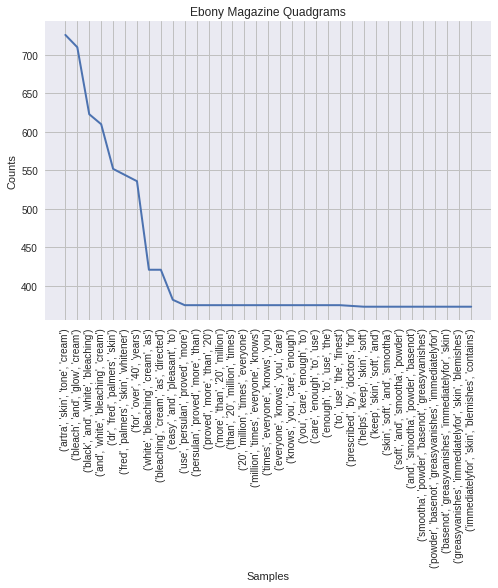

<AxesSubplot:title={'center':'Ebony Magazine Quadgrams'}, xlabel='Samples', ylabel='Counts'>

In [58]:
# A plot of ebony quadgrams
ebony_quadgram_freqs.plot(35, title="Ebony Magazine Quadgrams")

In [59]:
# Notice how the concordance for nomral shifts between "use on normal skin" or "for normal skin"
# carries a double meaning "for normal skin." The desire for "normal" skin collides with the
# assertion the product is safe because to admit otherwise would also admit that one's skin
# is somehow not normal. 
ebony_text_object.concordance("normal",120,200)

Displaying 200 of 664 matches:
ient laboratory proven for effectiveness and safe use on normal skin so soothing and refreshing too artras deepdown pene
ient laboratory proven for effectiveness and safe use on normal skin so soothing and refreshing too artras deepdown pene
ient laboratory proven for effectiveness and safe use on normal skin so soothing and refreshing too artras deepdown pene
ient laboratory proven for effectiveness and safe use on normal skin so soothing and refreshing too artras deepdown pene
ient laboratory proven for effectiveness and safe use on normal skin so soothing and refreshing too artras deepdown pene
ry tested hydroquinone the bleaching ingredient safe for normal skin artra not only lightens it creams your skin to clea
ns hydroquinone the bleaching ingredient proven safe for normal skin now lovelier lighter skin safelywuth artra skin ton
oquinone the miracleaction bleaching ingredient safe for normal skin artra softens your skin too now lovelier lighter sk
r

In [60]:
# Most common words in context for with keyword 'normal'
ebony_concord_list_obj = ebony_text_object.concordance_list("normal", 50)
ebony_concord_list = []
for con in ebony_concord_list_obj:
    sent = "".join(list(con[4:]))
    ebony_concord_list.append(sent)
ebony_concord_list_freqs = nltk.FreqDist(ebony_concord_list)
ebony_concord_list_freqs.most_common(10)

[('eness and safe use onskin so soothing and eness and safe use on normal skin so soothing and ',
  8),
 ('g ingredient safe forskin artra not only lg ingredient safe for normal skin artra not only l',
  4),
 ('g ingredient safe forskin artra softens yog ingredient safe for normal skin artra softens yo',
  3),
 ('and artra is safe forskin because it contaand artra is safe for normal skin because it conta',
  3),
 ('dient proven safe forskin now lovelier ligdient proven safe for normal skin now lovelier lig',
  1),
 ('dient proven safe forskin have you got thadient proven safe for normal skin have you got tha',
  1),
 ('dient proven safe forskin soft skin clear dient proven safe for normal skin soft skin clear ',
  1),
 ('en effective safe forskin with gentle laboen effective safe for normal skin with gentle labo',
  1),
 ('en effective safe forskin that velvetysoften effective safe for normal skin that velvetysoft',
  1),
 ('dient proven safe forskin look lighterwithdient proven safe f

In [61]:
ebony_text_object.concordance("modern",120,200)

Displaying 200 of 542 matches:
 its bleaching action works effectively inside your skin modern science knows no faster way of lightening skin mercolize
 its bleaching action works effectively inside your skin modern science knows no faster way of lightening skin lighter b
 its bleaching action works effectively inside your skin modern science knows no faster way of lightening skin life is m
 its bleaching action works effectively inside your skin modern science knows no faster way of lightening skin dr fred p
 its bleaching action works effectively inside your skin modern science knows no faster way of lightening skin egyptian 
 its bleachign action works effectively inside your skin modern science knows no faster way of lightening skin now a lov
 a lovelier lighter skin for youthanks to this wonder of modern science new artra skin tone cream with miracleaction hyd
 a lovelier lighter skin for youthanks to this wonder of modern science new artra skin tone cream with miracleaction hyd
 

<span id="terms_by_year"></span>
## Term Counts By Year
This section gives a sense of the shape and distribution of the data. We look at the distribution of terms of interest to the research team and compare their relative uses over time. 

In [62]:
#top twenty terms for Drum
terms_drum = [term[0] for term in drum_most_common_counts[:20]] 
print(terms_drum)

['skin', 'complexion', 'light', 'karroo', 'lighter', 'ambi', 'beautiful', 'lovely', 'beauty', 'makes', 'extra', 'cream', 'use', 'new', 'look', 'smooth', 'lightening', 'fast', 'night', 'lightens']


In [63]:
#top twenty terms in Ebony
terms_ebony = [term[0] for term in ebony_most_common_counts[:20]] 
print(terms_ebony)

['skin', 'cream', 'complexion', 'lighter', 'new', 'beauty', 'nadinola', 'dark', 'artra', 'use', 'look', 'glow', 'spots', 'brighter', 'tone', 'blackheads', 'bleach', 'bleaching', 'face', 'see']


In [64]:
terms = set(terms_drum + terms_ebony)
print(f"Of the 40 top terms from Ebony and Drum, there are {len(terms)} unique most frequent terms to plot by year.")
print()
print(terms)

Of the 40 top terms from Ebony and Drum, there are 32 unique most frequent terms to plot by year.

{'ambi', 'nadinola', 'new', 'tone', 'dark', 'extra', 'brighter', 'light', 'beautiful', 'bleaching', 'see', 'lovely', 'use', 'blackheads', 'look', 'skin', 'night', 'smooth', 'spots', 'cream', 'lightens', 'artra', 'bleach', 'beauty', 'face', 'fast', 'karroo', 'makes', 'lightening', 'complexion', 'lighter', 'glow'}


In [65]:
# Drum sentence tuples with date
claims_drum_sents = []
i = 0
for claim in claims_drum:
    temp_claim = "".join([ch for ch in claim if (ch.isalpha() or ch == " ") and ch not in string.punctuation]).lower()
    claims_drum_sents.append((str(claims_drum.keys()[i]),temp_claim))
    i += 1
print(claims_drum_sents[:2])
print(claims_drum_sents[-2:])

[('1965-01-01 00:00:00', 'to make their skin lighter and lovelierlovelier and lightera little more every day american scientist made artralightens and'), ('1965-01-01 00:00:00', 'brightens skin lightens from the first day vanishes into skin instantlystarts working starts lightening and brightening your skin')]
[('1987-11-01 00:00:00', 'trust heman to bring you a new fresh skin lightening lotion that really works  it gives you the light golden complexion that todays modern'), ('1987-11-01 00:00:00', 'successful women demand ready to help your skin gain the complexion you had  before the harsh south african sun changed it')]


In [66]:
# Ebony sentence tuples with date
claims_ebony_sents = []
i = 0
for claim in claims_ebony:
    temp_claim = "".join([ch for ch in claim if (ch.isalpha() or ch == " ") and ch not in string.punctuation]).lower()
    claims_ebony_sents.append((str(claims_ebony.keys()[i]),temp_claim))
    i += 1
print(claims_ebony_sents[:2])
print(claims_ebony_sents[-2:])

[('1960-01-01 00:00:00', '  wakes up dark dull complexion conceals ugly blotches blemishes while it bleaches guarantees lovelier lighter skin'), ('1960-01-01 00:00:00', 'if your skin doesnt look actually lighter after using mercolized wax cream for just one week your money will be cheerfully refunded youll see amazing results almost at once  as mercolized wax creams speedy bleaching action lightens your complexion fades dark blotches spots and freckles brings excessive skin oiliness under control works under the skin surface to bring about these marvelous results used by beautiful women for over  years')]
[('1990-12-01 00:00:00', 'created especially for you formula  fades dark marks lines age spots acne marks this remarkable cosmetic lightens knees elbows necksafely quickly and easily use it for stretchmarks freckles scars dont accept imitations'), ('1990-12-01 00:00:00', 'clear smooth new skin with safe effective  day peeling treatment treats acne scars pimples age lines dry blotchy s

In [67]:
# collect a list of years of publication, in this case for Ebony
# because our data spans from 1960 to 1990.

years = list(sorted(set([date[:4] for date, sent in claims_ebony_sents])))
print(years)

['1960', '1961', '1962', '1963', '1964', '1965', '1966', '1967', '1968', '1969', '1970', '1971', '1972', '1973', '1974', '1975', '1976', '1977', '1978', '1979', '1980', '1981', '1982', '1983', '1984', '1985', '1986', '1987', '1988', '1989', '1990']


In [68]:
# term counts from ad claims by year (1960-1990) and publication.

drum_term_counts = {}
ebony_term_counts = {}
combined_term_counts = {}
for term in terms:
    temp_term = []
    for year in years:
        e = 0
        for y,c in claims_ebony_sents:
            if str(year) == y[:4]:
                if term in c.split():
                    e += 1
        temp_term.append(e)
    ebony_term_counts[term] = temp_term
    combined_term_counts[term + " (Ebony)"] = temp_term # Added Ebony tag
    temp_term = []
    for year in years:
        e = 0
        for y,c in claims_drum_sents:
            if str(year) == y[:4]:
                if term in c.split():
                    e += 1
        temp_term.append(e)
    drum_term_counts[term] = temp_term
    combined_term_counts[term + " (Drum)"] = temp_term # Added Drum tag
combined_term_counts['years'] = years
print("Ebony Term Counts")
print(ebony_term_counts)
print("-"*100)
print("Drum Term Counts")
print(drum_term_counts)
print("-"*100)
print("Combined Term Counts")
print(combined_term_counts)

Ebony Term Counts
{'ambi': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 10, 6, 5, 6, 6, 4, 0, 7, 7, 6, 5, 8, 11, 5, 0], 'nadinola': [11, 14, 14, 13, 19, 17, 13, 9, 7, 5, 9, 4, 3, 0, 0, 2, 1, 4, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0], 'new': [26, 54, 35, 42, 43, 25, 19, 8, 6, 10, 28, 14, 0, 0, 0, 0, 0, 8, 4, 6, 6, 5, 2, 0, 1, 4, 7, 12, 18, 25, 13], 'tone': [9, 10, 3, 0, 16, 14, 6, 1, 3, 11, 17, 13, 4, 7, 11, 8, 14, 20, 10, 13, 12, 11, 12, 18, 8, 10, 16, 16, 15, 15, 6], 'dark': [25, 40, 19, 10, 17, 8, 10, 11, 11, 15, 20, 12, 3, 8, 15, 8, 15, 18, 11, 17, 17, 14, 12, 15, 8, 8, 11, 12, 18, 24, 20], 'extra': [0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 4, 1, 0, 0, 0], 'brighter': [19, 24, 35, 31, 41, 20, 15, 10, 3, 5, 0, 0, 0, 0, 0, 0, 5, 0, 0, 2, 3, 5, 2, 0, 0, 2, 0, 0, 0, 0, 0], 'light': [13, 24, 7, 4, 0, 3, 4, 0, 0, 0, 0, 0, 0, 0, 4, 2, 2, 3, 1, 2, 1, 0, 0, 0, 1, 2, 0, 0, 0, 2, 1], 'beautiful': [14, 20, 5, 5, 2, 10, 3, 3, 2, 7, 1, 2, 4, 5, 5, 5, 6, 14

In [69]:
# Ensure the shape of the data is consistent

print(len(drum_term_counts['beautiful']))
print(len(ebony_term_counts['beautiful']))
print(len(combined_term_counts['years']))

31
31
31


In [70]:
print("Drum Term Counts:")
drum_top_term_counts = []
for term in drum_term_counts:
    drum_term_sum = sum(map(int, drum_term_counts[term]))
    drum_top_term_counts.append((term, drum_term_sum))
for term in reversed(sorted(drum_top_term_counts, key = lambda x: x[1])):
    print("\t", term)

Drum Term Counts:
	 ('skin', 805)
	 ('complexion', 347)
	 ('lighter', 304)
	 ('smooth', 215)
	 ('light', 192)
	 ('lightens', 181)
	 ('fast', 171)
	 ('beautiful', 160)
	 ('spots', 136)
	 ('lovely', 118)
	 ('dark', 98)
	 ('lightening', 94)
	 ('cream', 92)
	 ('ambi', 89)
	 ('makes', 78)
	 ('extra', 78)
	 ('karroo', 73)
	 ('beauty', 73)
	 ('look', 73)
	 ('face', 58)
	 ('new', 58)
	 ('use', 54)
	 ('night', 53)
	 ('brighter', 42)
	 ('see', 25)
	 ('blackheads', 12)
	 ('bleaching', 12)
	 ('tone', 11)
	 ('artra', 6)
	 ('bleach', 4)
	 ('glow', 3)
	 ('nadinola', 0)


In [73]:
print("Ebony Term Counts:")
ebony_top_term_counts = []
for term in ebony_term_counts:
    ebony_term_sum = sum(map(int, ebony_term_counts[term]))
    ebony_top_term_counts.append((term, ebony_term_sum))
for term in reversed(sorted(ebony_top_term_counts, key = lambda x: x[1])):
    print("\t", term)

Ebony Term Counts:
	 ('skin', 1143)
	 ('cream', 679)
	 ('complexion', 512)
	 ('dark', 452)
	 ('new', 421)
	 ('spots', 386)
	 ('use', 385)
	 ('look', 371)
	 ('beauty', 369)
	 ('face', 365)
	 ('lighter', 351)
	 ('blackheads', 344)
	 ('see', 336)
	 ('smooth', 334)
	 ('tone', 329)
	 ('glow', 234)
	 ('brighter', 222)
	 ('beautiful', 189)
	 ('bleaching', 182)
	 ('bleach', 179)
	 ('nadinola', 149)
	 ('makes', 146)
	 ('lightens', 119)
	 ('lovely', 114)
	 ('night', 113)
	 ('ambi', 94)
	 ('artra', 93)
	 ('light', 76)
	 ('lightening', 67)
	 ('fast', 52)
	 ('extra', 15)
	 ('karroo', 0)


<ipython-input-74-53c56dc9f681>:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(years,rotation=90)


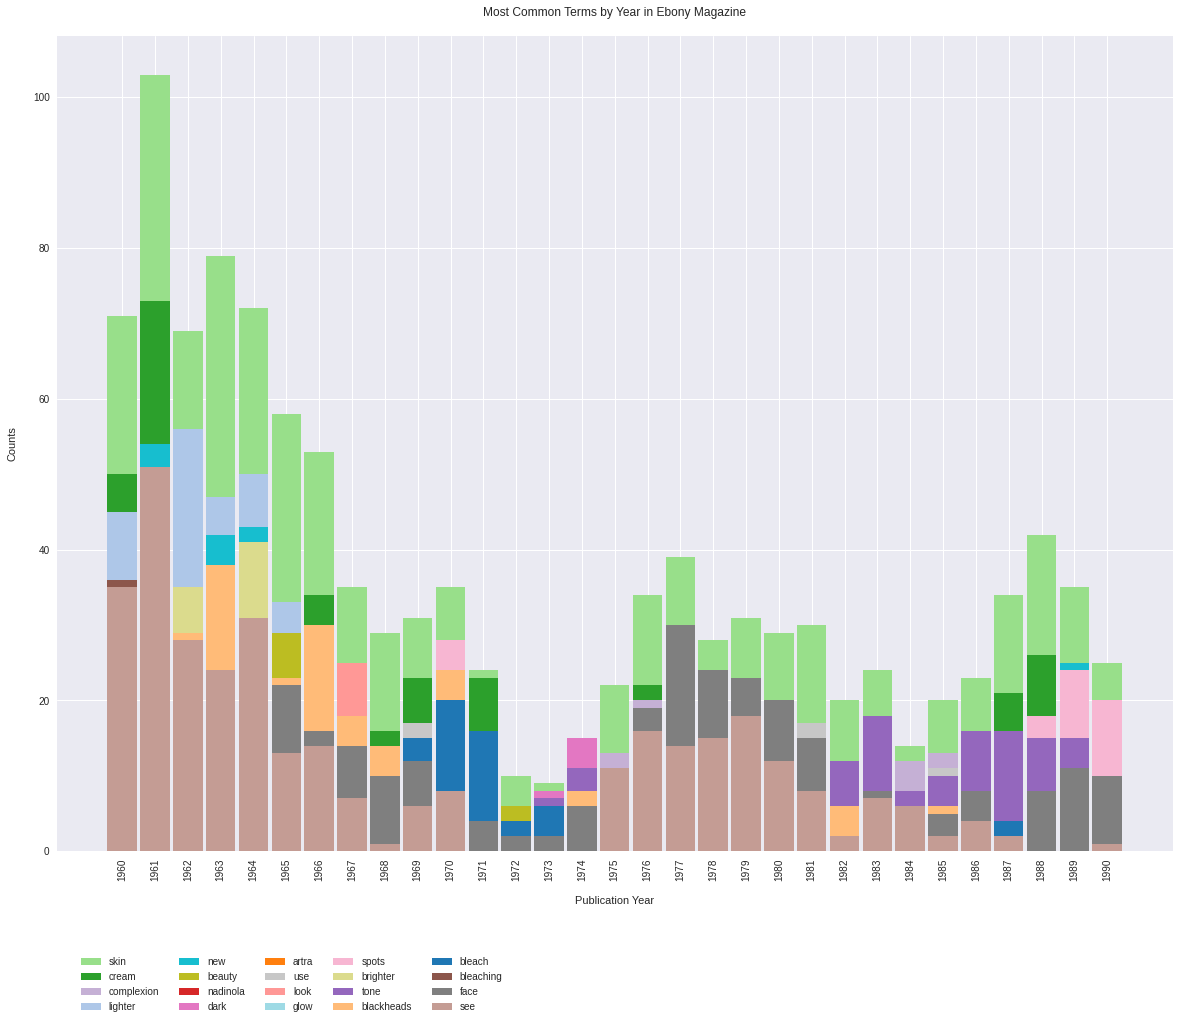

In [74]:
# graph made with Seaborn style in vanilla matplotlib
from matplotlib import cm # color maps import
from random import sample

width = 0.9

custom_cmap = plt.get_cmap('tab20')

fig, ax = plt.subplots(figsize=(20, 15))

color_vals = sample([num for num in range(0,20)], k=20)

counter = 0 

for term in terms_ebony:
    ax.bar(years, 
           ebony_term_counts[term], 
           width, 
           label=term, 
           align="center",
           color=custom_cmap.colors[color_vals[counter]])
    counter += 1
    
ax.set_ylabel("Counts\n")
ax.set_xlabel("\nPublication Year")
ax.set_title("Most Common Terms by Year in Ebony Magazine\n")
ax.set_xticklabels(years,rotation=90)
ax.legend(bbox_to_anchor=(0, -.1), 
          loc='upper left',
          ncol=5, 
          borderaxespad=2)
plt.show()
fig.savefig("most_common_terms_by_year_ebony.png")

<ipython-input-75-9bc6c08f05f5>:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(years,rotation=90)


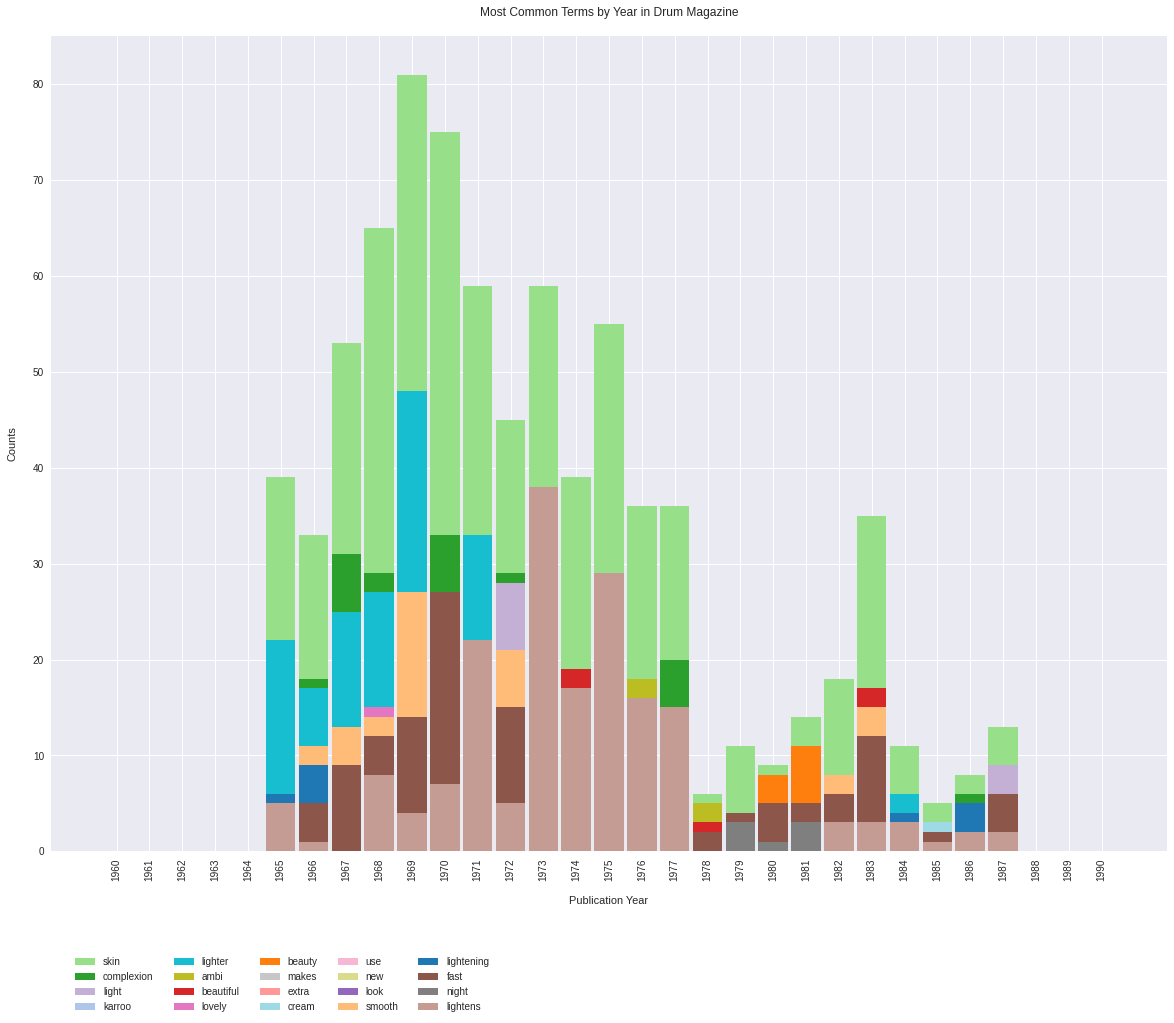

In [75]:
# graph made with Seaborn style in vanilla matplotlib

from matplotlib import cm # color maps import
from random import sample

width = 0.9

custom_cmap = plt.get_cmap('tab20')

fig, ax = plt.subplots(figsize=(20, 15))

# color_vals = sample([num for num in range(0,20)], k=20) #omit to keep colors consistent between graphs

counter = 0 

for term in terms_drum:
    ax.bar(years, 
           drum_term_counts[term], 
           width, 
           label=term, 
           align="center",
           color=custom_cmap.colors[color_vals[counter]])
    counter += 1
    
ax.set_ylabel("Counts\n")
ax.set_xlabel("\nPublication Year")
ax.set_title("Most Common Terms by Year in Drum Magazine\n")
ax.set_xticklabels(years,rotation=90)
ax.legend(bbox_to_anchor=(0, -.1), 
          loc='upper left',
          ncol=5, 
          borderaxespad=2)
plt.show()
fig.savefig("most_common_terms_by_year_drum.png")

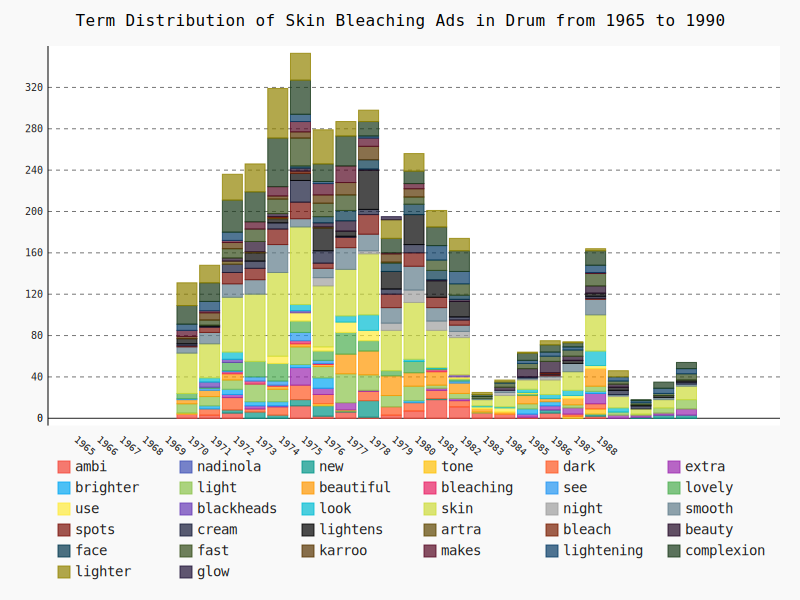

In [76]:
# original stacked bar graphs using PyGal library, disregard for stylistic consistency

line_chart = pygal.StackedBar(x_label_rotation=40, legend_at_bottom=True)
line_chart.title = 'Term Distribution of Skin Bleaching Ads in Drum from 1965 to 1990'
line_chart.x_labels = map(str, range(1965, 1989))
for term in terms:
    line_chart.add(term, drum_term_counts[term])
display(SVG(line_chart.render(disable_xml_declaration=True))) 
line_chart.render_to_file("drum_term_counts_by_year.svg")

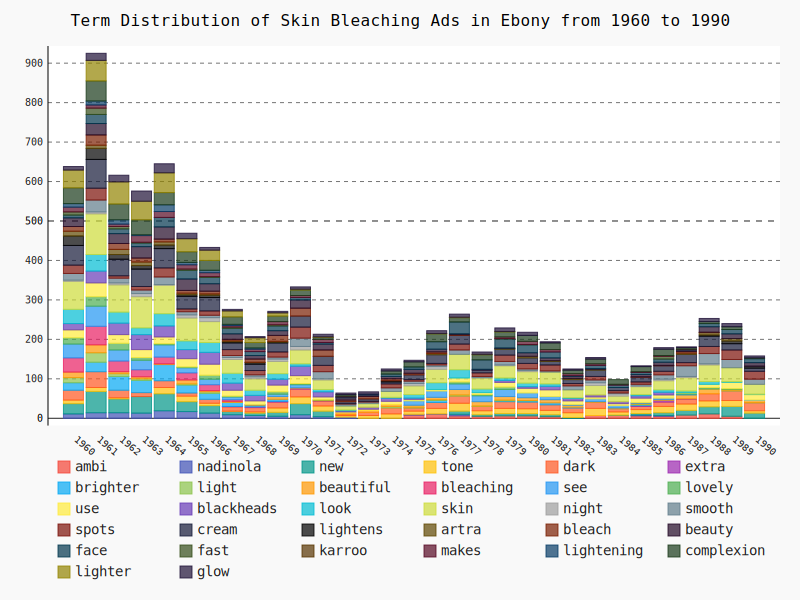

In [77]:
# original stacked bar graphs using PyGal library, disregard for stylistic consistency

line_chart = pygal.StackedBar(x_label_rotation=40, legend_at_bottom=True)
line_chart.title = 'Term Distribution of Skin Bleaching Ads in Ebony from 1960 to 1990'
line_chart.x_labels = map(str, range(1960, 1991))
for term in terms:
    line_chart.add(term, ebony_term_counts[term])
display(SVG(line_chart.render(disable_xml_declaration=True))) 
line_chart.render_to_file("ebony_term_counts_by_year.svg")

In [78]:
drum_counts = []
ebony_counts = []
for year in years_ebony:
    e = 0
    for y,c in claims_ebony_sents:
        if str(year) == y[:4]:
            e += 1
    ebony_counts.append(e)
    d = 0
    for y,c in claims_drum_sents:
        if str(year) == y[:4]:
            d += 1
    drum_counts.append(d)
print(ebony_counts)
print(drum_counts)

[72, 103, 74, 82, 72, 58, 54, 36, 31, 34, 35, 24, 10, 9, 15, 22, 35, 39, 28, 31, 29, 32, 20, 24, 14, 20, 23, 34, 42, 41, 31]
[0, 0, 0, 0, 0, 46, 62, 93, 108, 132, 134, 96, 80, 99, 60, 82, 65, 68, 6, 12, 22, 28, 25, 57, 15, 7, 10, 17, 0, 0, 0]


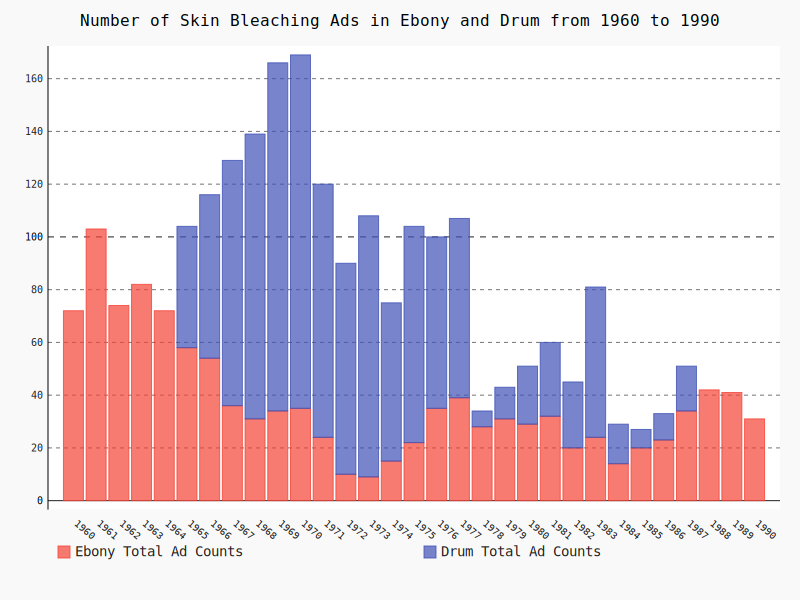

In [79]:
# original stacked bar graphs using PyGal library, disregard for stylistic consistency

line_chart = pygal.StackedBar(x_label_rotation=40, legend_at_bottom=True)
line_chart.title = 'Number of Skin Bleaching Ads in Ebony and Drum from 1960 to 1990'
line_chart.x_labels = map(str, range(1960, 1991))
line_chart.add("Ebony Total Ad Counts", ebony_counts)
line_chart.add("Drum Total Ad Counts", drum_counts)
display(SVG(line_chart.render(disable_xml_declaration=True))) 
line_chart.render_to_file("drum_and_ebony_ad_counts_by_year.svg")

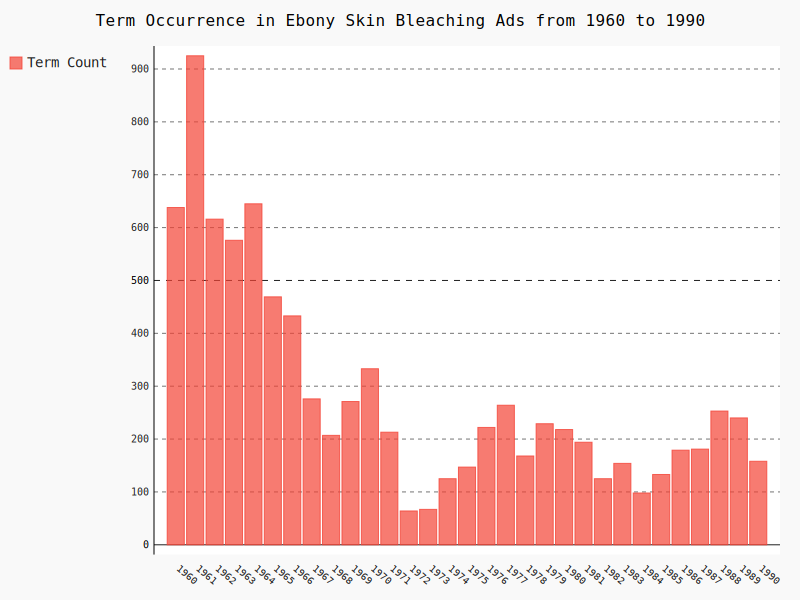

In [80]:
# original stacked bar graphs using PyGal library, disregard for stylistic consistency

line_chart = pygal.StackedBar(x_label_rotation=40)
line_chart.title = 'Term Occurrence in Ebony Skin Bleaching Ads from 1960 to 1990'
line_chart.x_labels = map(str, range(1960, 1991))
ebony_year_list = []
for year in years_ebony:
    i = 0
    for y,c in claims_ebony_sents:
        if str(year) == y[:4]:
            for term in terms:
                if term in c.split():
                    i += 1
    ebony_year_list.append(i)
line_chart.add("Term Count", ebony_year_list)
display(SVG(line_chart.render(disable_xml_declaration=True))) 
line_chart.render_to_file("ebony_term_occurrence_by_year.svg")

In [81]:
claims_drum = claims_drum.dropna()
#claims_drum.replace(',','',regex = True) 

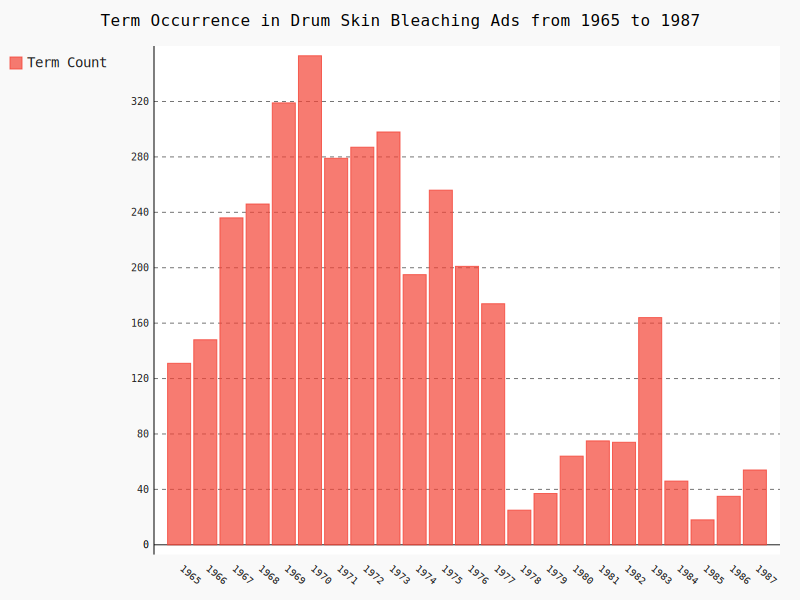

In [82]:
# original stacked bar graphs using PyGal library, disregard for stylistic consistency

line_chart = pygal.StackedBar(x_label_rotation=40)
line_chart.title = 'Term Occurrence in Drum Skin Bleaching Ads from 1965 to 1987'
line_chart.x_labels = map(str, range(1965, 1988))
drum_year_list = []
for year in years_drum:
    i = 0
    for y,c in claims_drum_sents:
        if str(year) == y[:4]:
            for term in terms:
                if term in c.split():
                    i += 1
    drum_year_list.append(i)
line_chart.add("Term Count", drum_year_list)
display(SVG(line_chart.render(disable_xml_declaration=True))) 
line_chart.render_to_file("drum_term_occurrence_by_year.svg")

In [83]:
fill = [None for n in range(0,5)]

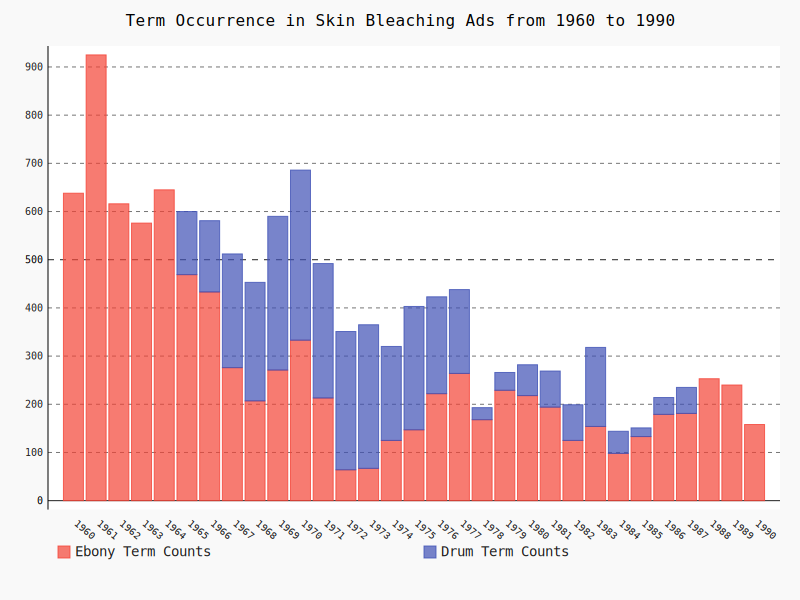

In [84]:
# original stacked bar graphs using PyGal library, disregard for stylistic consistency

line_chart = pygal.StackedBar(x_label_rotation=40, legend_at_bottom=True)
line_chart.title = 'Term Occurrence in Skin Bleaching Ads from 1960 to 1990'
line_chart.x_labels = map(str, range(1960, 1991))
line_chart.add("Ebony Term Counts", ebony_year_list)
line_chart.add("Drum Term Counts", fill+drum_year_list)
display(SVG(line_chart.render(disable_xml_declaration=True))) 
line_chart.render_to_file("drum_and_ebony_term_occurrence_by_year.svg")

In [85]:
def add(list_counts):
    total = 0
    for i in list_counts:
        total += i
    return total

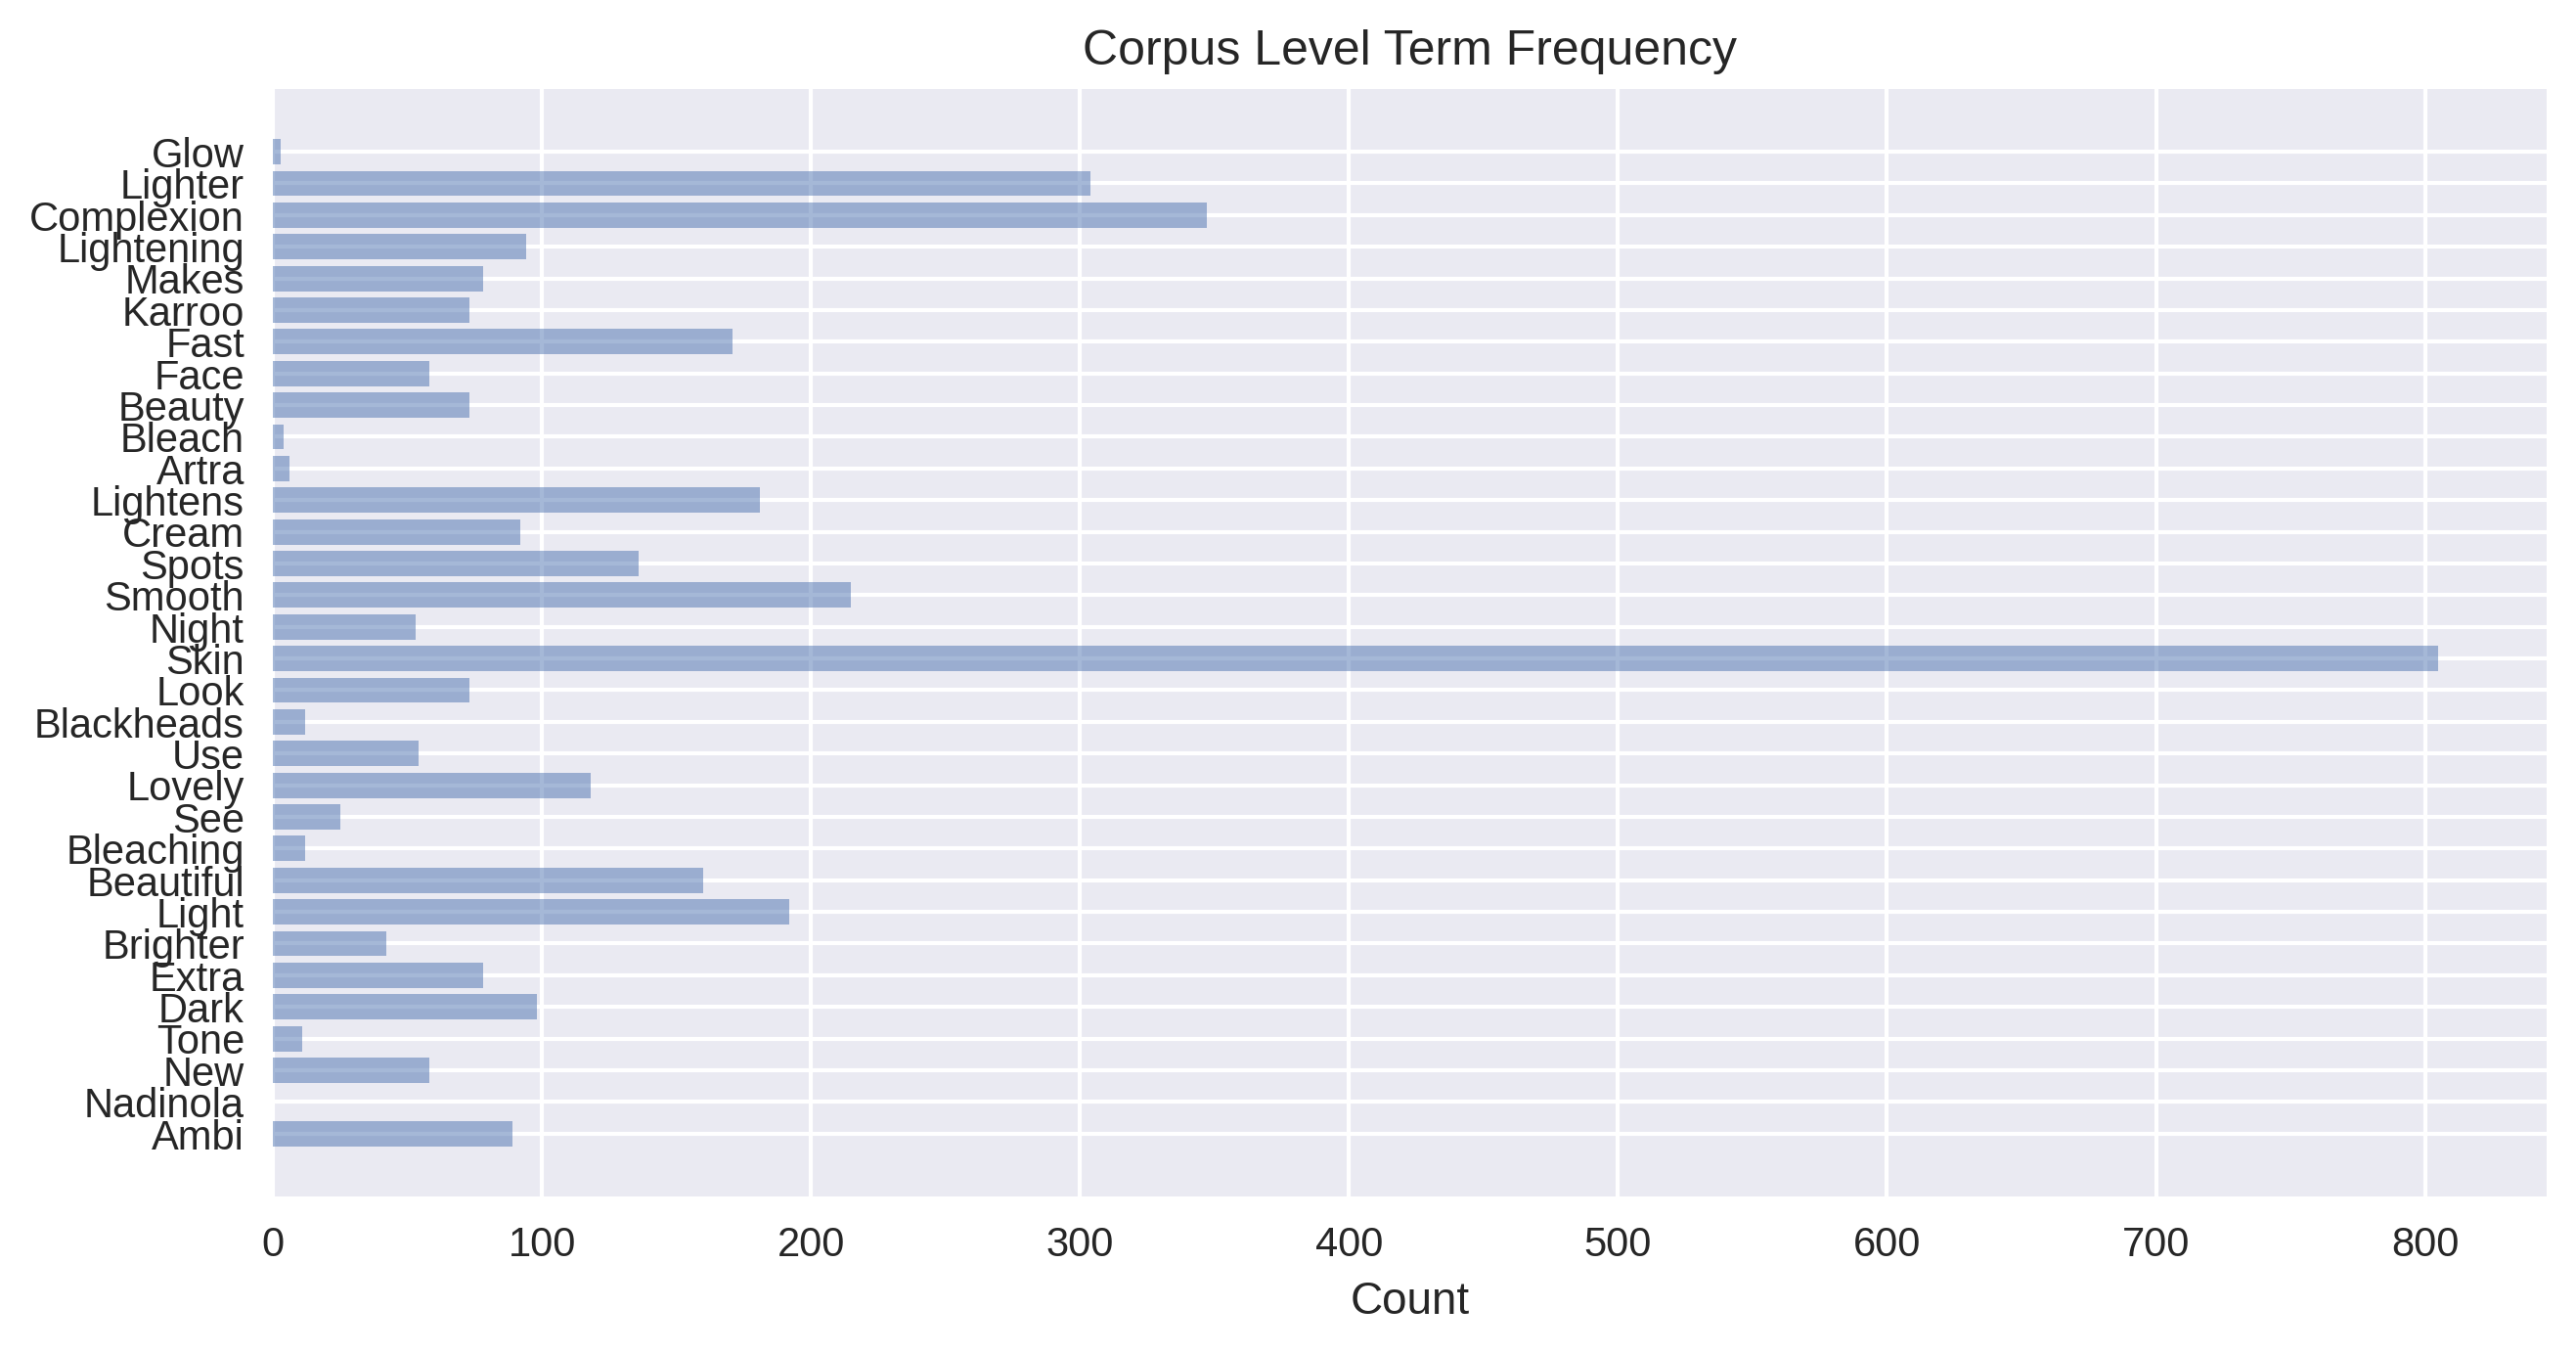

In [86]:
successfig = plt.figure(figsize=(10, 5), dpi=300)
objects = tuple([term.capitalize() for term in terms])
corpus_counts = dict(ebony_term_counts, **drum_term_counts)
termS1 = [add(count) for word,count in corpus_counts.items() if word in terms]
y_pos = np.arange(len(termS1))

plt.barh(y_pos, termS1, align='center', alpha=.5)
plt.yticks(y_pos, objects, fontsize = 10)
plt.xlabel('Count')
plt.title('Corpus Level Term Frequency')
 
plt.show()
successfig.savefig("corpus_freqs.png")

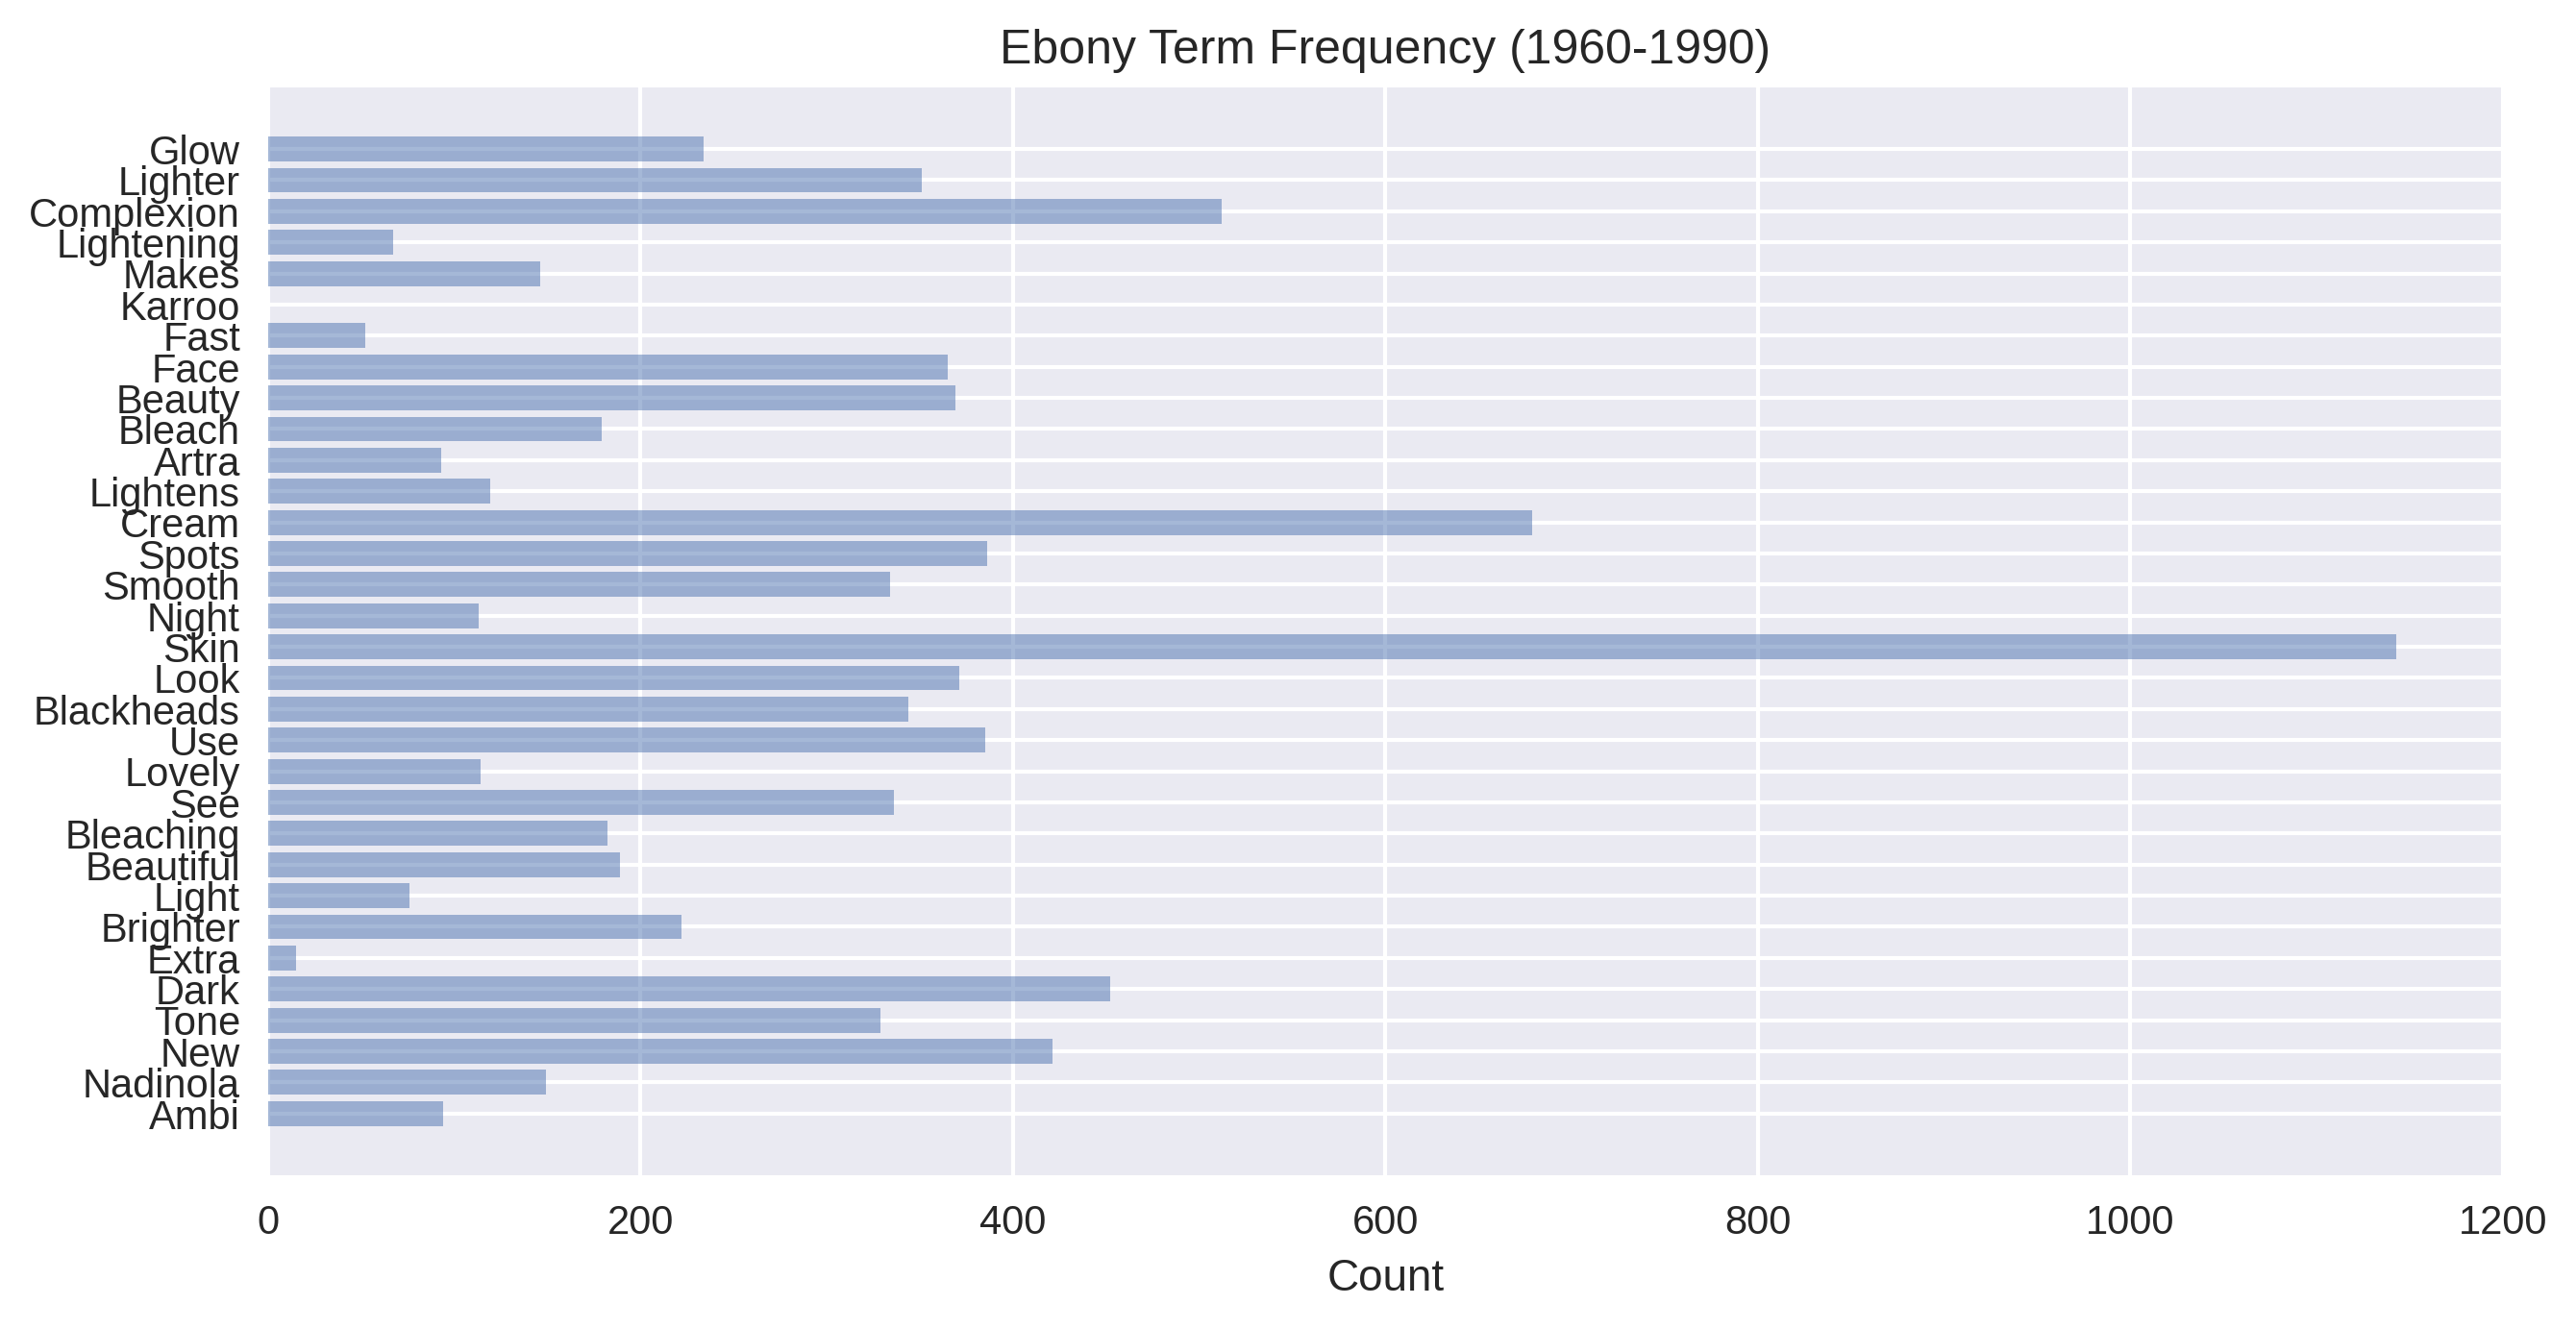

In [87]:
successfig = plt.figure(figsize=(10, 5), dpi=300)
objects = tuple([term.capitalize() for term in terms])
termS1 = [add(count) for word,count in ebony_term_counts.items() if word in terms]
y_pos = np.arange(len(termS1))

plt.barh(y_pos, termS1, align='center', alpha=.5)
plt.yticks(y_pos, objects, fontsize = 10)
plt.xlabel('Count')
plt.title('Ebony Term Frequency (1960-1990)')
 
plt.show()
successfig.savefig("ebony_freqs.png")

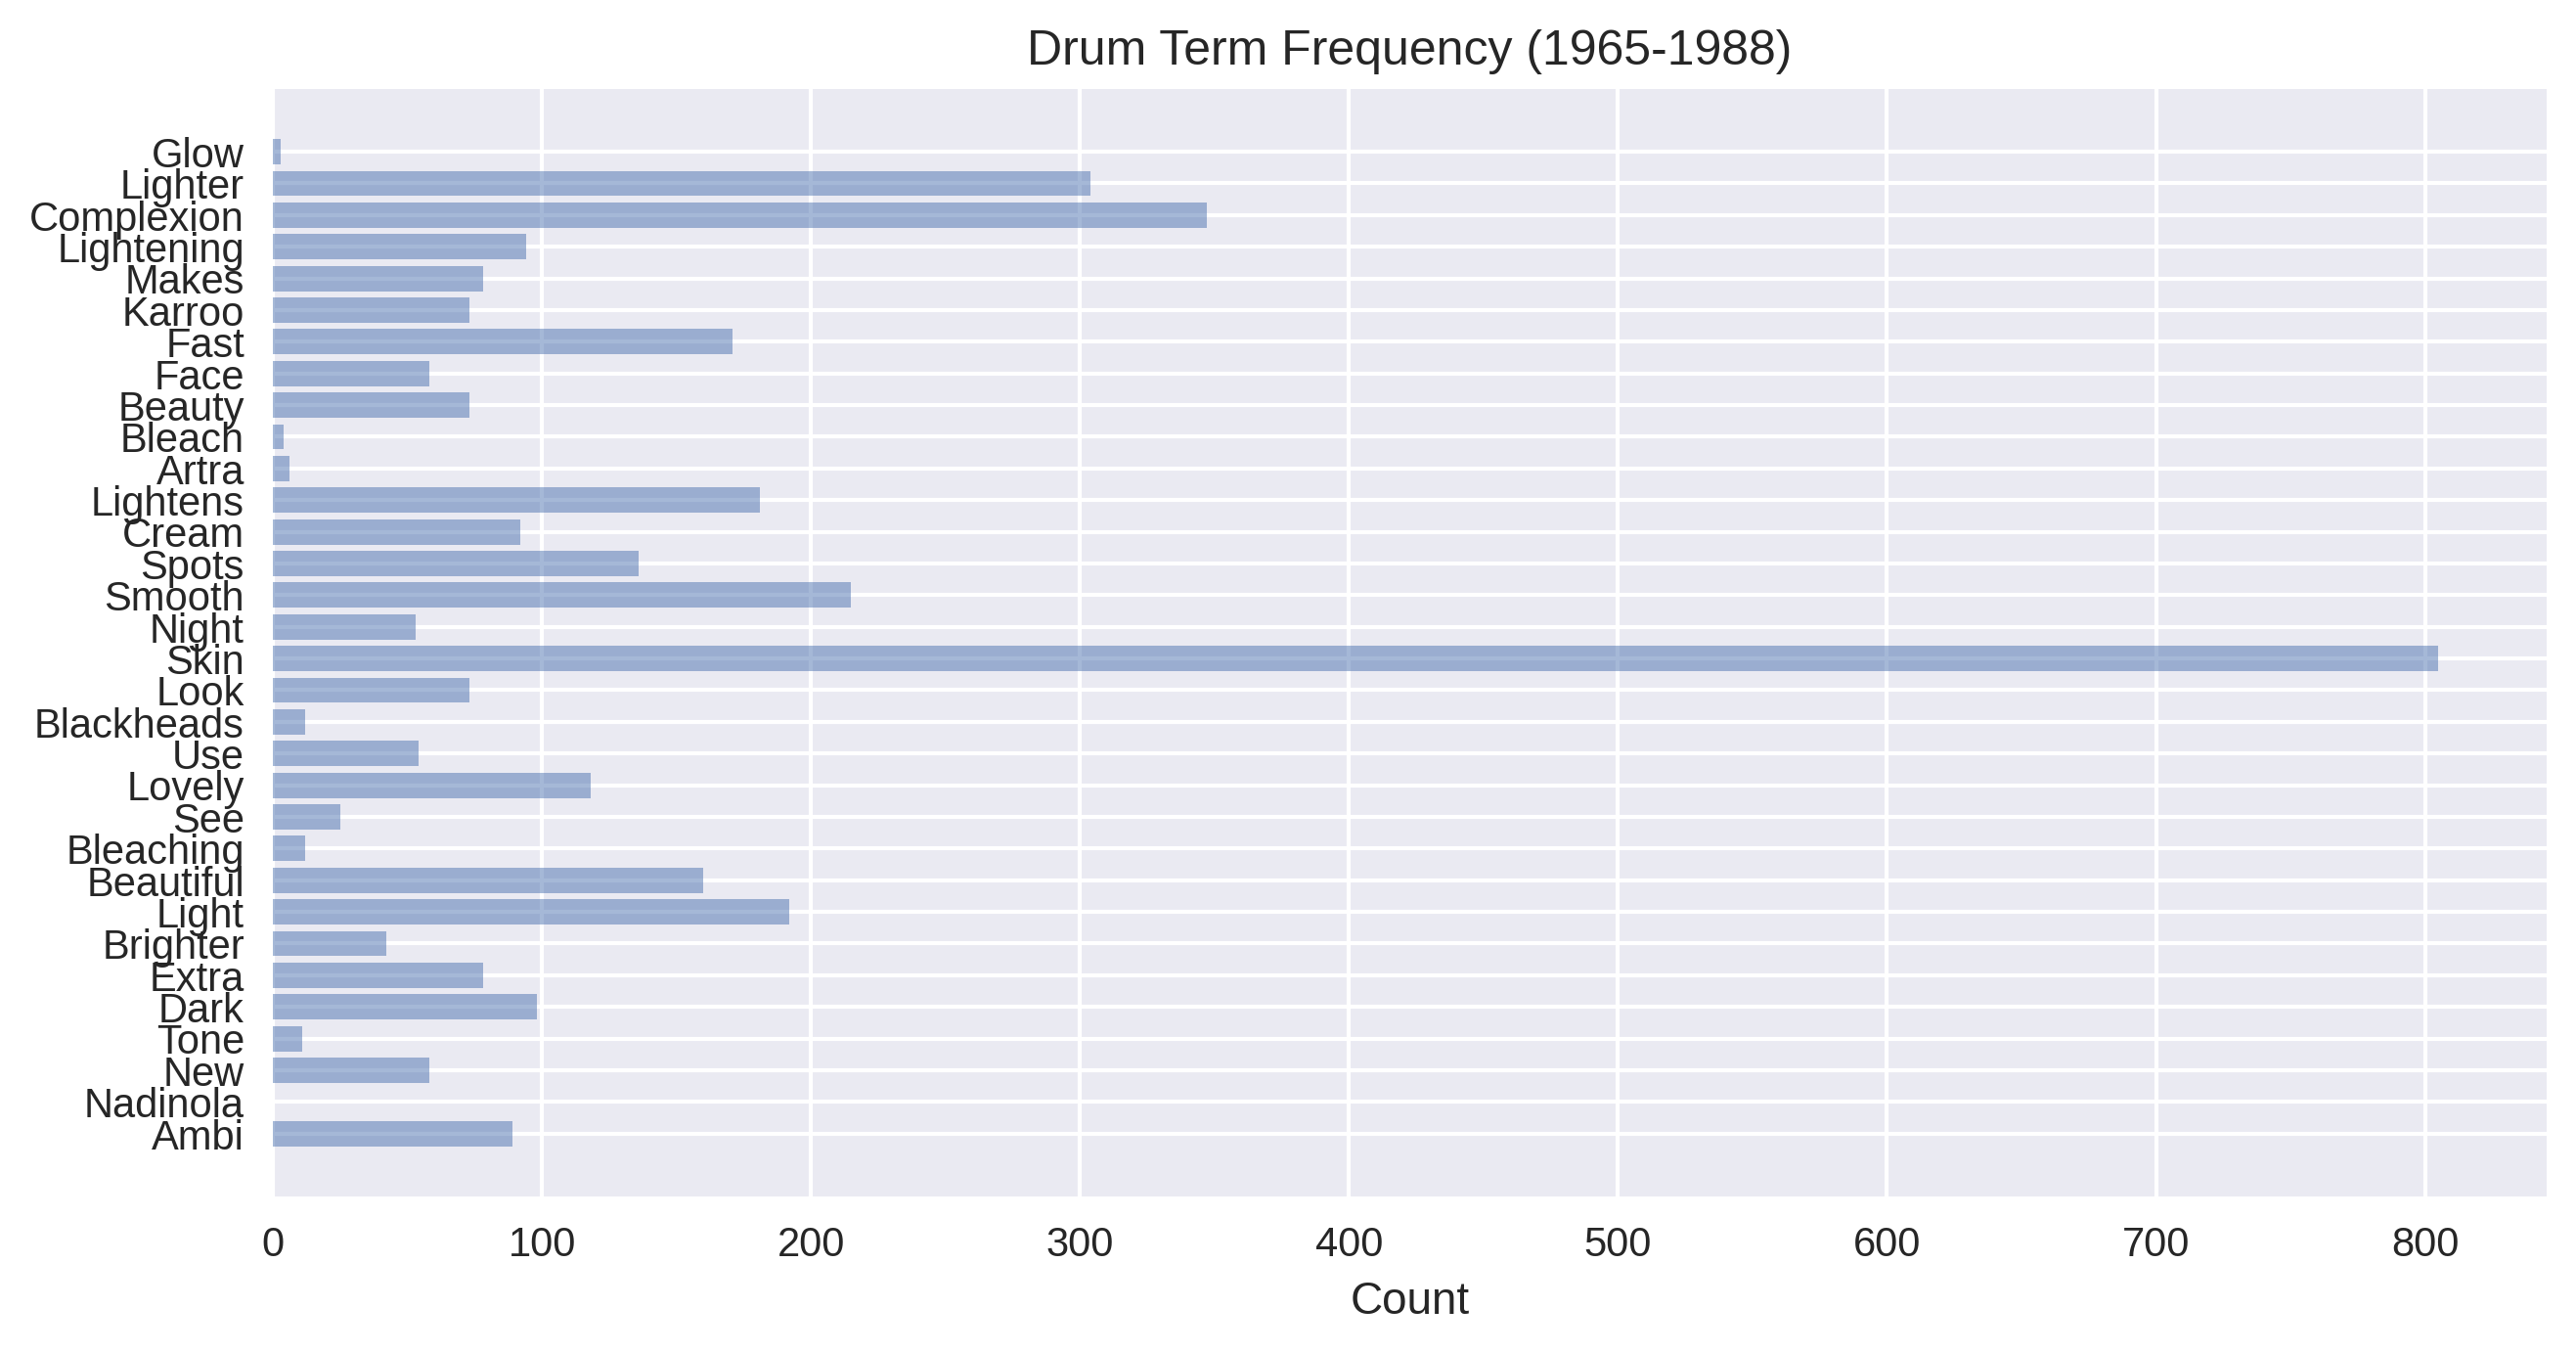

In [88]:
successfig = plt.figure(figsize=(10, 5), dpi=300)
objects = tuple([term.capitalize() for term in terms])
termS1 = [add(count) for word,count in drum_term_counts.items() if word in terms]
y_pos = np.arange(len(termS1))

plt.barh(y_pos, termS1, align='center', alpha=.5)
plt.yticks(y_pos, objects, fontsize = 10)
plt.xlabel('Count')
plt.title('Drum Term Frequency (1965-1988)')
 
plt.show()
successfig.savefig("drum_freqs.png")

<Figure size 240000x165000 with 0 Axes>

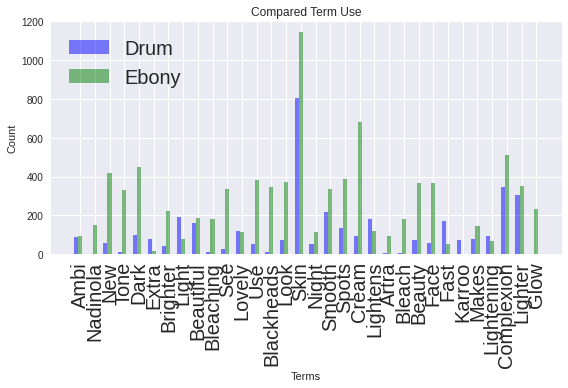

In [89]:
# data to plot
n_groups = len(objects)
fig = plt.figure(figsize=(800, 550), dpi=300)
# create plot
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.28
opacity = 0.5

 
rects1 = plt.bar(index, [add(count) for word,count in drum_term_counts.items() if word in terms], bar_width,
                 alpha=opacity,
                 color='b',
                 label='Drum')
 
rects2 = plt.bar(index + bar_width, [add(count) for word,count in ebony_term_counts.items() if word in terms], bar_width,
                 alpha=opacity,
                 color='g',
                 label='Ebony')
 
plt.xlabel('Terms')
plt.ylabel('Count')
plt.title('Compared Term Use')
plt.xticks(index + bar_width, objects)
plt.xticks(rotation=90, size=20)
plt.legend(loc=2, prop={'size': 20})
 
plt.tight_layout()
plt.show()
fig.savefig("compared_term_use.png")

<span id="pos"></span>
# Parts of Speech

In [90]:
print("Drum Sample")
print(drum_claims_phrase_list[:5])
print("Ebony Sample")
print(ebony_claims_phrase_list[:5])

Drum Sample
[["Lighter, lovelier skin today…the American way!'", "…to make their skin lighter and lovelier…lovelier and lighter…a little more every day' '…American scientist made artra…lightens and"], ["Lighter, lovelier skin today…the American way!'", "brightens skin.' '…lightens from the first day.' '…vanishes into skin instantly…starts working, starts lightening and brightening your skin"], ["Lighter, lovelier skin today…the American way!'", "immediately.' '…keeps skin beautiful and clean, makes it smooth and lovely"], ["Lighter, lovelier skin today…the American way!'", '…mild and gentle…keeps skin free from blemishes and pimples'], ["Lighter, lovelier skin today…the American way!'", "…clears and lightens the skin, smooth's away blemishes and spots, softens the skin'"]]
Ebony Sample
[['"Mercolized Wax Cream guarantees lighter looking skin in just 7 days or money back!"', '" - wakes up dark, dull complexion! Conceals ugly blotches, blemishes while it bleaches. Guarantees lovelier, li

In [91]:
drum_tags = []
for ad in drum_claims_phrase_list:
    for sent in ad:
        tokens = nltk.word_tokenize(str(sent))
        tagged = nltk.pos_tag(tokens)
        drum_tags.append(tagged)

In [92]:
drum_tags_list = list(itertools.chain.from_iterable(drum_tags))
drum_tags_list[:25]

[('Lighter', 'NNP'),
 (',', ','),
 ('lovelier', 'JJR'),
 ('skin', 'FW'),
 ('today…the', 'JJ'),
 ('American', 'JJ'),
 ('way', 'NN'),
 ('!', '.'),
 ("'", "''"),
 ('…to', 'NNS'),
 ('make', 'VBP'),
 ('their', 'PRP$'),
 ('skin', 'NN'),
 ('lighter', 'NN'),
 ('and', 'CC'),
 ('lovelier…lovelier', 'JJR'),
 ('and', 'CC'),
 ('lighter…a', 'VB'),
 ('little', 'RB'),
 ('more', 'RBR'),
 ('every', 'DT'),
 ('day', 'NN'),
 ("'", 'POS'),
 ("'…American", 'JJ'),
 ('scientist', 'NN')]

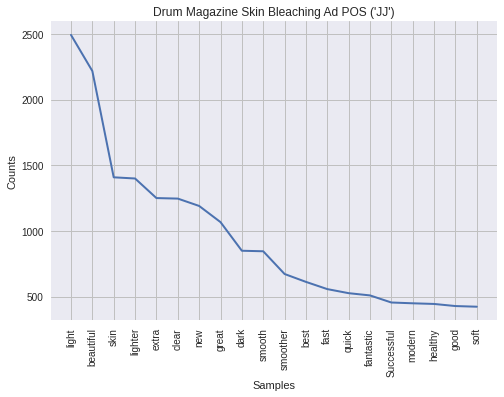

<AxesSubplot:title={'center':"Drum Magazine Skin Bleaching Ad POS ('JJ')"}, xlabel='Samples', ylabel='Counts'>

In [93]:
# In the most common adjects in Drum Magazine, we can confirm many of the terms used previously.
# The assocation of success and modernity, along with "healthy" confirm the attempts to 
# legitimize these products. 
adjectives = [token for token,pos in drum_tags_list if "JJ" in pos]
adjFreqs = nltk.FreqDist(adjectives)
adjFreqs.plot(20, title="Drum Magazine Skin Bleaching Ad POS ('JJ')")

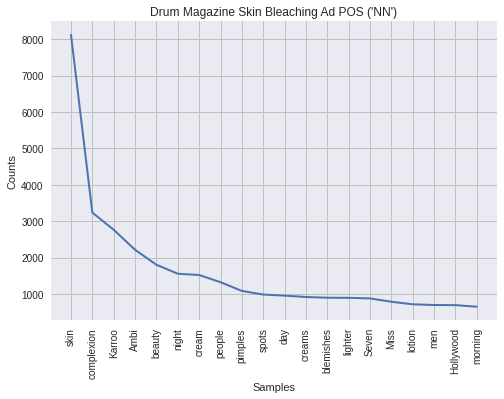

<AxesSubplot:title={'center':"Drum Magazine Skin Bleaching Ad POS ('NN')"}, xlabel='Samples', ylabel='Counts'>

In [94]:
# When considering nouns only, it is remarkable that the majority of terms reference 
# more neutral beauty based phrases. The references to Hollywood confirms the connection to a US
# sense of success and beauty.
nouns = [token for token,pos in drum_tags_list if "NN" in pos]
adjFreqs = nltk.FreqDist(nouns)
adjFreqs.plot(20, title="Drum Magazine Skin Bleaching Ad POS ('NN')")

In [95]:
drum_text_object.concordance("Hollywood",120,200)

Displaying 200 of 1048 matches:
s clear and light and lovely the strong one for mennew hollywood seven extra extra for men skin as clear and lovely as 
s without blemishes or spots the strong one for mennew hollywood seven extra extra for men cream which gives the comple
 and new freckle free beauty the strong one for mennew hollywood seven extra extra for men lighter softer smoother comp
r softer smoother complexion the strong one for mennew hollywood seven extra extra for men if your skin is dark rough o
imple freckle and complexion the strong one for mennew hollywood seven extra extra for men lotion quick results the str
for men lotion quick results the strong one for mennew hollywood seven extra extra for men lighter smoother skins does 
es less of the brown pigment the strong one for mennew hollywood seven extra extra for men makes your skin naturally li
 your skin naturally lighter the strong one for mennew hollywood seven extra extra for men lighter clearer complexion s
ticed su

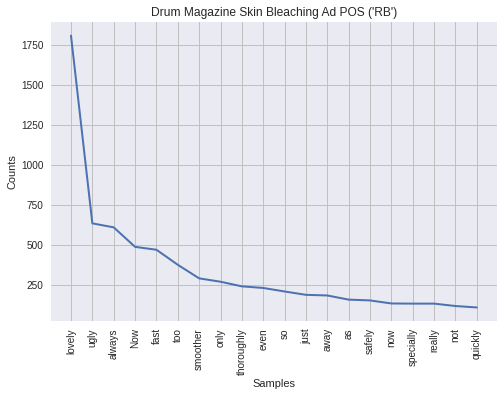

<AxesSubplot:title={'center':"Drum Magazine Skin Bleaching Ad POS ('RB')"}, xlabel='Samples', ylabel='Counts'>

In [96]:
# The collocation of "lovely" and "ugly" is remarkable
adverbs = [token for token,pos in drum_tags_list if "RB" == pos]
adjFreqs = nltk.FreqDist(adverbs)
adjFreqs.plot(20, title="Drum Magazine Skin Bleaching Ad POS ('RB')")

In [97]:
# Ugly spots "spoilt" complexions
drum_text_object.concordance("ugly",120,200)

Displaying 200 of 787 matches:
kin is dark rough or dull or your complexion is spoilt by ugly spots and pimples use super rose pimple freckle and compl
kin is dark rough or dull or your complexion is spoilt by ugly spots and pimples use super rose pimple freckle and compl
kin is dark rough or dull or your complexion is spoilt by ugly spots and pimples use super rose pimple freckle and compl
kin is dark rough or dull or your complexion is spoilt by ugly spots and pimples use super rose pimple freckle and compl
kin is dark rough or dull or your complexion is spoilt by ugly spots and pimples use super rose pimple freckle and compl
kin is dark rough or dull or your complexion is spoilt by ugly spots and pimples use super rose pimple freckle and compl
kin is dark rough or dull or your complexion is spoilt by ugly spots and pimples use super rose pimple freckle and compl
kin is dark rough or dull or your complexion is spoilt by ugly spots and pimples use super rose pimple freckle and compl
k

In [98]:
# Lovely is associated with beauty, clear, and bright. 
drum_text_object.concordance("lovely",120,200)

Displaying 200 of 2262 matches:
ately keeps skin beautiful and clean makes it smooth and lovely lighter lovelier skin todaythe american way mild and gen
 skin todaythe american way the sooner you startexpect a lovely clear bright complexion cream your skin lighter and brig
ately keeps skin beautiful and clean makes it smooth and lovely cream your skin lighter and brighter with amazing new ar
hter with amazing new artra the sooner you startexpect a lovely clear bright complexion medicated soap for complexion ca
ately keeps skin beautiful and clean makes it smooth and lovely medicated soap for complexion care mild and gentlekeeps 
ed soap for complexion care the sooner you startexpect a lovely clear bright complexion good things happen to a pretty g
ately keeps skin beautiful and clean makes it smooth and lovely good things happen to a pretty girl mild and gentlekeeps
ngs happen to a pretty girl the sooner you startexpect a lovely clear bright complexion see notes to make their skin lig


## Ebony POS

In [99]:
ebony_tags = []
for ad in ebony_claims_phrase_list:
    for sent in ad:
        tokens = nltk.word_tokenize(str(sent))
        tagged = nltk.pos_tag(tokens)
        ebony_tags.append(tagged)

In [100]:
ebony_tags_list = list(itertools.chain.from_iterable(ebony_tags))
ebony_tags_list[:20]

[('``', '``'),
 ('Mercolized', 'VBN'),
 ('Wax', 'NNP'),
 ('Cream', 'NNP'),
 ('guarantees', 'NNS'),
 ('lighter', 'VBP'),
 ('looking', 'VBG'),
 ('skin', 'NN'),
 ('in', 'IN'),
 ('just', 'RB'),
 ('7', 'CD'),
 ('days', 'NNS'),
 ('or', 'CC'),
 ('money', 'NN'),
 ('back', 'RB'),
 ('!', '.'),
 ("''", "''"),
 ('``', '``'),
 ('-', ':'),
 ('wakes', 'VBZ')]

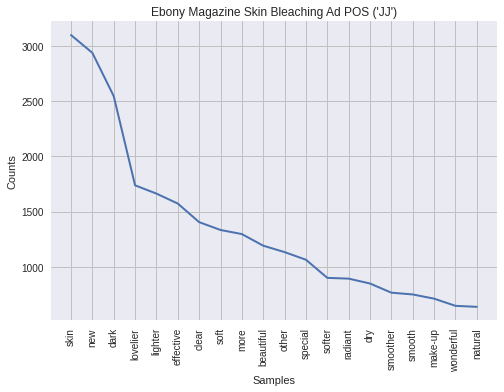

<AxesSubplot:title={'center':"Ebony Magazine Skin Bleaching Ad POS ('JJ')"}, xlabel='Samples', ylabel='Counts'>

In [101]:
adjectives = [token for token,pos in ebony_tags_list if "JJ" in pos]
adjFreqs = nltk.FreqDist(adjectives)
adjFreqs.plot(20, title="Ebony Magazine Skin Bleaching Ad POS ('JJ')")

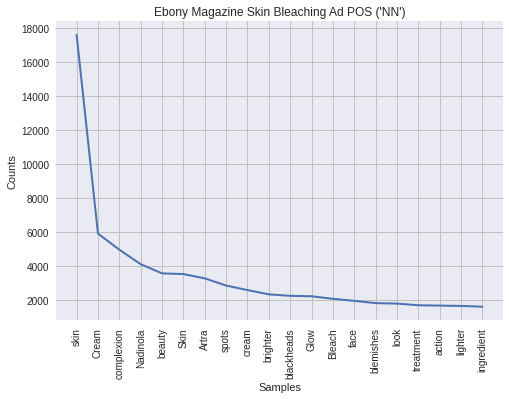

<AxesSubplot:title={'center':"Ebony Magazine Skin Bleaching Ad POS ('NN')"}, xlabel='Samples', ylabel='Counts'>

In [102]:
nouns = [token for token,pos in ebony_tags_list if "NN" in pos]
adjFreqs = nltk.FreqDist(nouns)
adjFreqs.plot(20, title="Ebony Magazine Skin Bleaching Ad POS ('NN')")

In [103]:
ebony_text_object.concordance("glow",120,200)

Displaying 200 of 3139 matches:
nd clean biggest beauty value you ever saw new bleach and glow leaves your skin shades lighter clearer smoother its fabu
 effective by thousands of satisfied users new bleach and glow leaves your skin shades lighter clearer smoother its fabu
ghter fairer lovelier skinso easily yours with bleach and glow the look of total loveliness family size jar of nadinola 
ghter fairer lovelier skinso easily yours with bleach and glow the look of total loveliness now a complexion cream for l
ghter fairer lovelier skinso easily yours with bleach and glow the look of total loveliness new bleach and glow leaves y
each and glow the look of total loveliness new bleach and glow leaves your skin shades lighter clearer smoother its fabu
ghter fairer lovelier skinso easily yours with bleach and glow the look of total loveliness if your skin doesnt look act
ghter fairer lovelier skinso easily yours with bleach and glow the look of total loveliness see your dull dark skin take


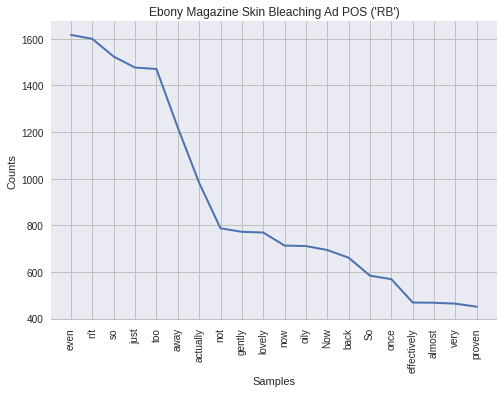

<AxesSubplot:title={'center':"Ebony Magazine Skin Bleaching Ad POS ('RB')"}, xlabel='Samples', ylabel='Counts'>

In [104]:
adjectives = [token for token,pos in ebony_tags_list if "RB" == pos]
adjFreqs = nltk.FreqDist(adjectives)
adjFreqs.plot(20, title="Ebony Magazine Skin Bleaching Ad POS ('RB')")

# Drum Magazine Topic Model

In [105]:
drum_claims_phrase = []
for c, p in drum_claims_phrase_list:
    cp = str(c) + str(p)
    drum_claims_phrase.append(cp)

In [106]:
lemma = WordNetLemmatizer()

In [107]:
exclude = set(string.punctuation)

In [108]:
stop = set(stopwords.words('english'))

In [109]:
def preprocess(doc):
    remove_stops=" ".join([i for i in doc.lower().split() if i not in stop])
    remove_punct="".join(character for character in remove_stops if character not in exclude)
    normalized=" ".join(lemma.lemmatize(word) for word in remove_punct.split())
    return normalized

In [110]:
cleaned_doc = [preprocess(doc).split() for doc in drum_claims_phrase]

In [111]:
dictionary = corpora.Dictionary(cleaned_doc)

In [112]:
doc_term_matrix = [dictionary.doc2bow(doc) for doc in cleaned_doc]

In [113]:
lda = gensim.models.ldamodel.LdaModel

In [114]:
ldamodel = lda(doc_term_matrix, num_topics=10, id2word = dictionary, passes=20)

In [115]:
drum_topics = ldamodel.print_topics(num_topics=10, num_words=5)
print(drum_topics)

[(0, '0.086*"extra" + 0.075*"skin" + 0.056*"fast" + 0.046*"treatment" + 0.046*"hollywood"'), (1, '0.066*"dark" + 0.042*"spot" + 0.041*"blemish" + 0.040*"face" + 0.039*"neck"'), (2, '0.043*"skin" + 0.038*"light" + 0.037*"new" + 0.034*"get" + 0.029*"cream"'), (3, '0.177*"skin" + 0.037*"smooth" + 0.037*"now" + 0.033*"beautiful" + 0.031*"new"'), (4, '0.067*"pimple" + 0.060*"skin" + 0.056*"beautiful" + 0.049*"super" + 0.048*"ugly"'), (5, '0.079*"skin" + 0.054*"lotion" + 0.048*"extra" + 0.046*"heman" + 0.040*"beautiful"'), (6, '0.072*"look" + 0.068*"skin" + 0.067*"ambi" + 0.035*"lighter" + 0.025*"looking"'), (7, '0.084*"karroo" + 0.078*"lovely" + 0.077*"make" + 0.048*"night" + 0.043*"skin"'), (8, '0.060*"complexion" + 0.055*"skin" + 0.042*"beautiful" + 0.032*"soft" + 0.030*"smooth"'), (9, '0.085*"people" + 0.081*"successful" + 0.069*"skin" + 0.059*"use" + 0.050*"top"')]


In [116]:
drum_topic_list=[]
for score,topic in drum_topics:
    topic_vals=[tuple(top.split("*")) for top in topic.split(" +")]
    drum_topic_list.append(topic_vals)

In [117]:
drum_topic_list

[[('0.086', '"extra"'),
  (' 0.075', '"skin"'),
  (' 0.056', '"fast"'),
  (' 0.046', '"treatment"'),
  (' 0.046', '"hollywood"')],
 [('0.066', '"dark"'),
  (' 0.042', '"spot"'),
  (' 0.041', '"blemish"'),
  (' 0.040', '"face"'),
  (' 0.039', '"neck"')],
 [('0.043', '"skin"'),
  (' 0.038', '"light"'),
  (' 0.037', '"new"'),
  (' 0.034', '"get"'),
  (' 0.029', '"cream"')],
 [('0.177', '"skin"'),
  (' 0.037', '"smooth"'),
  (' 0.037', '"now"'),
  (' 0.033', '"beautiful"'),
  (' 0.031', '"new"')],
 [('0.067', '"pimple"'),
  (' 0.060', '"skin"'),
  (' 0.056', '"beautiful"'),
  (' 0.049', '"super"'),
  (' 0.048', '"ugly"')],
 [('0.079', '"skin"'),
  (' 0.054', '"lotion"'),
  (' 0.048', '"extra"'),
  (' 0.046', '"heman"'),
  (' 0.040', '"beautiful"')],
 [('0.072', '"look"'),
  (' 0.068', '"skin"'),
  (' 0.067', '"ambi"'),
  (' 0.035', '"lighter"'),
  (' 0.025', '"looking"')],
 [('0.084', '"karroo"'),
  (' 0.078', '"lovely"'),
  (' 0.077', '"make"'),
  (' 0.048', '"night"'),
  (' 0.043', '"ski

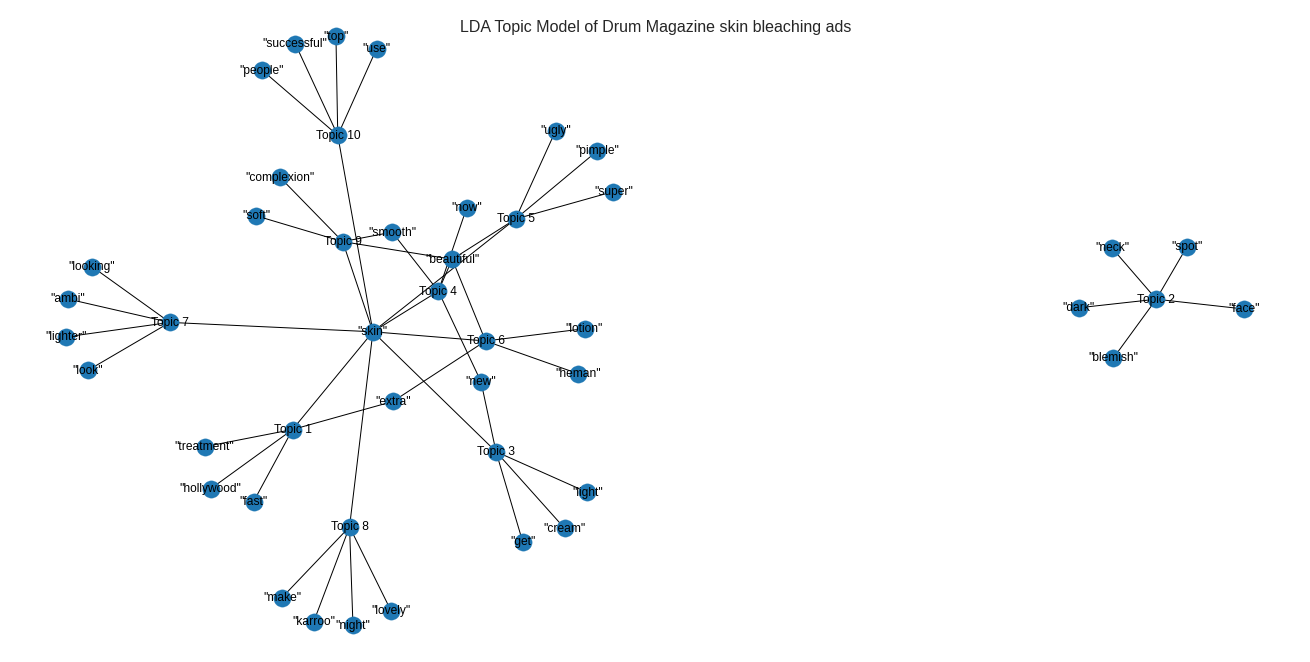

In [118]:
G = nx.Graph()
top_num = 0
for topics in drum_topic_list:
    top_num += 1
    G.add_node("Topic "+str(top_num))
    for topic in topics:
        G.add_node(topic[1])
        G.add_edge("Topic "+str(top_num), topic[1])
plt.figure(figsize=(18,9))
plt.suptitle("LDA Topic Model of Drum Magazine skin bleaching ads", fontsize=16)
nx.draw(G, with_labels=True)
plt.savefig("./drum_LDA_network.png")

# Ebony Magazine Topic Model

In [119]:
claims_ebony.head()

Year
1960-01-01    " - wakes up dark, dull complexion! Conceals u...
1960-01-01    "If your skin doesn't look actually lighter af...
1960-01-01    "And you, too, can have a glamorous complexion...
1960-01-01    "Don't let dull, dark skin rob you of romance....
1960-01-01    "Yes in just 7 days be delighted how fast and ...
Name: Claims, dtype: object

In [120]:
catch_phrase_ebony.head()

Year
1960-01-01    "Mercolized Wax Cream guarantees lighter looki...
1960-01-01             "Lighter, brighter skin is irresistable"
1960-01-01    "LIFE IS MORE FUN when your complexion is clea...
1960-01-01    "DR. FRED PALMER'S IN JUST 7 DAYS MUST GIVE YO...
1960-01-01    "Egyptian formula BLEACH CRÈME gives amazing r...
Name: Advertising strategy *quotes-catch phrase*, dtype: object

In [121]:
ebony_catch_phrase_and_claims = pd.merge(catch_phrase_ebony, claims_ebony, right_index=True, left_index=True)

In [122]:
ebony_claims_phrase_list = ebony_catch_phrase_and_claims.values.tolist()

In [123]:
ebony_claims_phrase_list[:10]

[['"Mercolized Wax Cream guarantees lighter looking skin in just 7 days or money back!"',
  '" - wakes up dark, dull complexion! Conceals ugly blotches, blemishes while it bleaches. Guarantees lovelier, lighter skin."'],
 ['"Mercolized Wax Cream guarantees lighter looking skin in just 7 days or money back!"',
  '"If your skin doesn\'t look actually lighter after using Mercolized Wax Cream for just one week, your money will be cheerfully refunded."; "You\'ll see amazing results almost at once - as Mercolized Wax Cream\'s speedy bleaching action lightens your complexion, fades dark blotches, spots, and freckles, brings excessive skin oiliness under control."; "...works under the skin surface to bring about these marvelous results."; "Used by beautiful women for over 40 years."'],
 ['"Mercolized Wax Cream guarantees lighter looking skin in just 7 days or money back!"',
  '"And you, too, can have a glamorous complexion!"; "…see your skin get a lighter, brighter, softer look."; "Its bleachi

In [124]:
ebony_claims_phrase = []
for c, p in ebony_claims_phrase_list:
    cp = str(c) + str(p)
    ebony_claims_phrase.append(cp)

In [125]:
ebony_cleaned_doc = [preprocess(doc).split() for doc in ebony_claims_phrase]

In [126]:
dictionary = corpora.Dictionary(ebony_cleaned_doc)

In [127]:
doc_term_matrix = [dictionary.doc2bow(doc) for doc in ebony_cleaned_doc]

In [128]:
lda = gensim.models.ldamodel.LdaModel

In [129]:
ldamodel = lda(doc_term_matrix, num_topics=10, id2word = dictionary, passes=20)

In [130]:
ebony_topics = ldamodel.print_topics(num_topics=10, num_words=5)
print(ebony_topics)

[(0, '0.071*"nadinola" + 0.030*"skin" + 0.026*"complexion" + 0.018*"deluxe" + 0.016*"beauty"'), (1, '0.059*"skin" + 0.039*"fair" + 0.033*"cream" + 0.021*"mercolized" + 0.021*"crème"'), (2, '0.075*"skin" + 0.042*"cream" + 0.032*"fade" + 0.027*"e" + 0.026*"vitamin"'), (3, '0.069*"skin" + 0.023*"effective" + 0.021*"lighter" + 0.019*"ingredient" + 0.018*"care"'), (4, '0.069*"skin" + 0.061*"treatment" + 0.039*"peelerpak" + 0.036*"6" + 0.033*"day"'), (5, '0.061*"skin" + 0.023*"cream" + 0.022*"even" + 0.021*"help" + 0.020*"ambi"'), (6, '0.063*"skin" + 0.055*"artra" + 0.049*"esoterica" + 0.027*"cream" + 0.026*"new"'), (7, '0.039*"spot" + 0.037*"dark" + 0.026*"fade" + 0.024*"vantex" + 0.024*"skin"'), (8, '0.090*"skin" + 0.029*"cream" + 0.027*"lighter" + 0.025*"bleaching" + 0.025*"brighter"'), (9, '0.078*"skin" + 0.077*"glow" + 0.069*"bleach" + 0.034*"cream" + 0.020*"complexion"')]


In [131]:
ebony_topic_list=[]
for score,topic in ebony_topics:
    topic_vals=[tuple(top.split("*")) for top in topic.split(" +")]
    ebony_topic_list.append(topic_vals)

In [132]:
ebony_topic_list

[[('0.071', '"nadinola"'),
  (' 0.030', '"skin"'),
  (' 0.026', '"complexion"'),
  (' 0.018', '"deluxe"'),
  (' 0.016', '"beauty"')],
 [('0.059', '"skin"'),
  (' 0.039', '"fair"'),
  (' 0.033', '"cream"'),
  (' 0.021', '"mercolized"'),
  (' 0.021', '"crème"')],
 [('0.075', '"skin"'),
  (' 0.042', '"cream"'),
  (' 0.032', '"fade"'),
  (' 0.027', '"e"'),
  (' 0.026', '"vitamin"')],
 [('0.069', '"skin"'),
  (' 0.023', '"effective"'),
  (' 0.021', '"lighter"'),
  (' 0.019', '"ingredient"'),
  (' 0.018', '"care"')],
 [('0.069', '"skin"'),
  (' 0.061', '"treatment"'),
  (' 0.039', '"peelerpak"'),
  (' 0.036', '"6"'),
  (' 0.033', '"day"')],
 [('0.061', '"skin"'),
  (' 0.023', '"cream"'),
  (' 0.022', '"even"'),
  (' 0.021', '"help"'),
  (' 0.020', '"ambi"')],
 [('0.063', '"skin"'),
  (' 0.055', '"artra"'),
  (' 0.049', '"esoterica"'),
  (' 0.027', '"cream"'),
  (' 0.026', '"new"')],
 [('0.039', '"spot"'),
  (' 0.037', '"dark"'),
  (' 0.026', '"fade"'),
  (' 0.024', '"vantex"'),
  (' 0.024', 

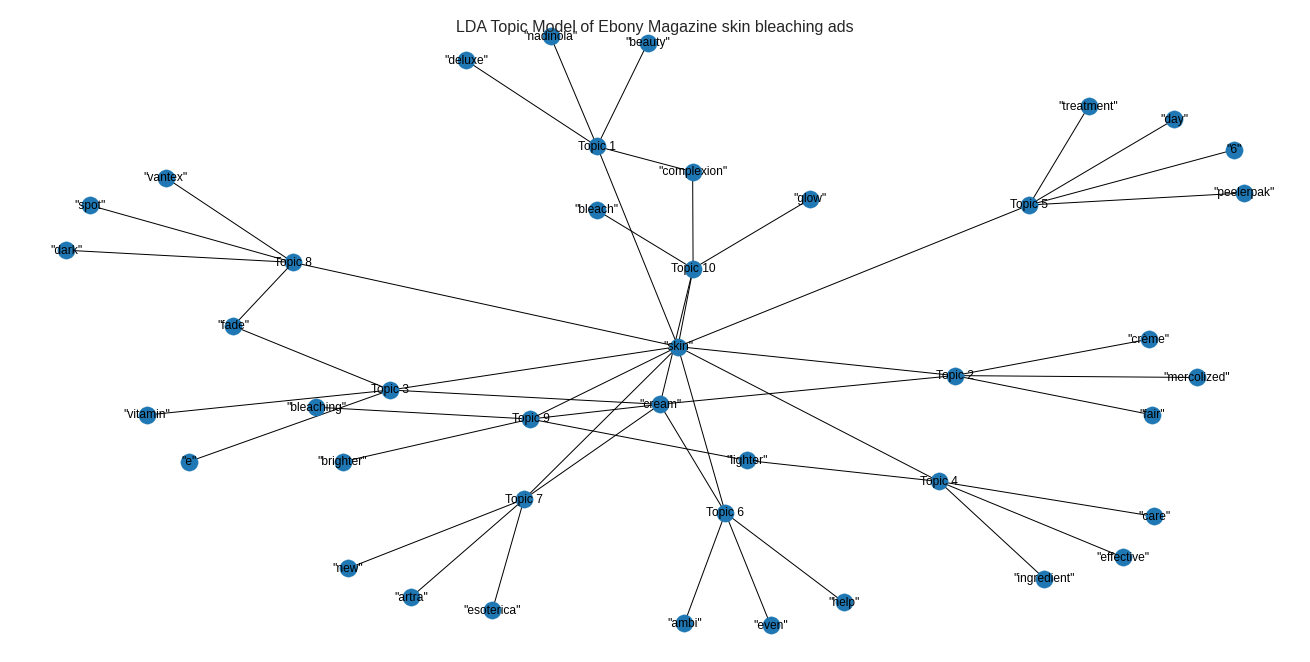

In [133]:
G = nx.Graph()
top_num = 0
for topics in ebony_topic_list:
    top_num += 1
    G.add_node("Topic "+str(top_num))
    for topic in topics:
        G.add_node(topic[1])
        G.add_edge("Topic "+str(top_num), topic[1])
plt.figure(figsize=(18,9))
plt.suptitle("LDA Topic Model of Ebony Magazine skin bleaching ads", fontsize=16)
nx.draw(G, with_labels=True)
plt.savefig("./ebony_LDA_network.png")

# Drum and Ebony Topics

In [134]:
both_catch_phrase_and_claims = pd.merge(drum_catch_phrase_and_claims, ebony_catch_phrase_and_claims, right_index=True, left_index=True)

In [135]:
both_claims_phrase_list = both_catch_phrase_and_claims.values.tolist()

In [136]:
both_claims_phrase_list[:10]

[["Lighter, lovelier skin today…the American way!'",
  "…to make their skin lighter and lovelier…lovelier and lighter…a little more every day' '…American scientist made artra…lightens and",
  '"New faster-working formula"; "Discover Ultra Nadinola for a brighter, lighter, more even-toned look in all these beauty areas"; "new Ultra Nadinola for skin discolorations"',
  '"Wonderful new ULTRA Nadinola is a specially forumated moisturizing cream that brings you the lightening, brightening magic of Hydroquinone. It actually seeks out and fades dark areas to a softer, more golden-toned glow. Meanwhile, it smooths and freshens the clearer areas. Remarkable improvement usually comes after using a single tube of ULTRA Nadinola. After that, occasional use may be needed to keep your lighter, brighter, uniform skin tone. ULTRA Nadinola also contains a \'sun screen\' to help protect sun-sensitive skin and preserve its new freshness and clearness. Start your new complexion today. Extensive clinical 

In [137]:
both_claims_phrase = []
for c1, p1, c2, p2 in both_claims_phrase_list:
    cp = str(c1) + str(p1) + str(c2) + str(p2)
    both_claims_phrase.append(cp)

In [138]:
cleaned_doc = [preprocess(doc).split() for doc in both_claims_phrase]

In [139]:
dictionary = corpora.Dictionary(cleaned_doc)

In [140]:
doc_term_matrix = [dictionary.doc2bow(doc) for doc in cleaned_doc]

In [141]:
lda = gensim.models.ldamodel.LdaModel

In [142]:
ldamodel = lda(doc_term_matrix, num_topics=10, id2word = dictionary, passes=20)

In [143]:
both_topics = ldamodel.print_topics(num_topics=10, num_words=5)
print(both_topics)

[(0, '0.082*"year" + 0.074*"skin" + 0.042*"large" + 0.034*"look" + 0.030*"cream"'), (1, '0.088*"skin" + 0.054*"thats" + 0.046*"nadinola" + 0.042*"beautiful" + 0.038*"oily"'), (2, '0.072*"skin" + 0.031*"treatment" + 0.028*"peelerpak" + 0.025*"6" + 0.024*"day"'), (3, '0.089*"skin" + 0.033*"dark" + 0.032*"help" + 0.027*"tone" + 0.020*"work"'), (4, '0.068*"skin" + 0.049*"palmer" + 0.033*"formula" + 0.031*"aid" + 0.030*"using"'), (5, '0.046*"ultra" + 0.039*"skin" + 0.038*"spot" + 0.036*"dark" + 0.035*"lemon"'), (6, '0.093*"glow" + 0.083*"bleach" + 0.061*"skin" + 0.041*"cream" + 0.034*"beauty"'), (7, '0.087*"ambi" + 0.078*"skin" + 0.037*"cream" + 0.035*"tone" + 0.032*"artra"'), (8, '0.038*"result" + 0.031*"superficial" + 0.027*"skin" + 0.026*"formulated" + 0.024*"eye"'), (9, '0.115*"esoterica" + 0.054*"skin" + 0.036*"surface" + 0.032*"cream" + 0.030*"hand"')]


In [144]:
both_topic_list=[]
for score,topic in both_topics:
    topic_vals=[tuple(top.split("*")) for top in topic.split(" +")]
    both_topic_list.append(topic_vals)

In [145]:
both_topic_list

[[('0.082', '"year"'),
  (' 0.074', '"skin"'),
  (' 0.042', '"large"'),
  (' 0.034', '"look"'),
  (' 0.030', '"cream"')],
 [('0.088', '"skin"'),
  (' 0.054', '"thats"'),
  (' 0.046', '"nadinola"'),
  (' 0.042', '"beautiful"'),
  (' 0.038', '"oily"')],
 [('0.072', '"skin"'),
  (' 0.031', '"treatment"'),
  (' 0.028', '"peelerpak"'),
  (' 0.025', '"6"'),
  (' 0.024', '"day"')],
 [('0.089', '"skin"'),
  (' 0.033', '"dark"'),
  (' 0.032', '"help"'),
  (' 0.027', '"tone"'),
  (' 0.020', '"work"')],
 [('0.068', '"skin"'),
  (' 0.049', '"palmer"'),
  (' 0.033', '"formula"'),
  (' 0.031', '"aid"'),
  (' 0.030', '"using"')],
 [('0.046', '"ultra"'),
  (' 0.039', '"skin"'),
  (' 0.038', '"spot"'),
  (' 0.036', '"dark"'),
  (' 0.035', '"lemon"')],
 [('0.093', '"glow"'),
  (' 0.083', '"bleach"'),
  (' 0.061', '"skin"'),
  (' 0.041', '"cream"'),
  (' 0.034', '"beauty"')],
 [('0.087', '"ambi"'),
  (' 0.078', '"skin"'),
  (' 0.037', '"cream"'),
  (' 0.035', '"tone"'),
  (' 0.032', '"artra"')],
 [('0.03

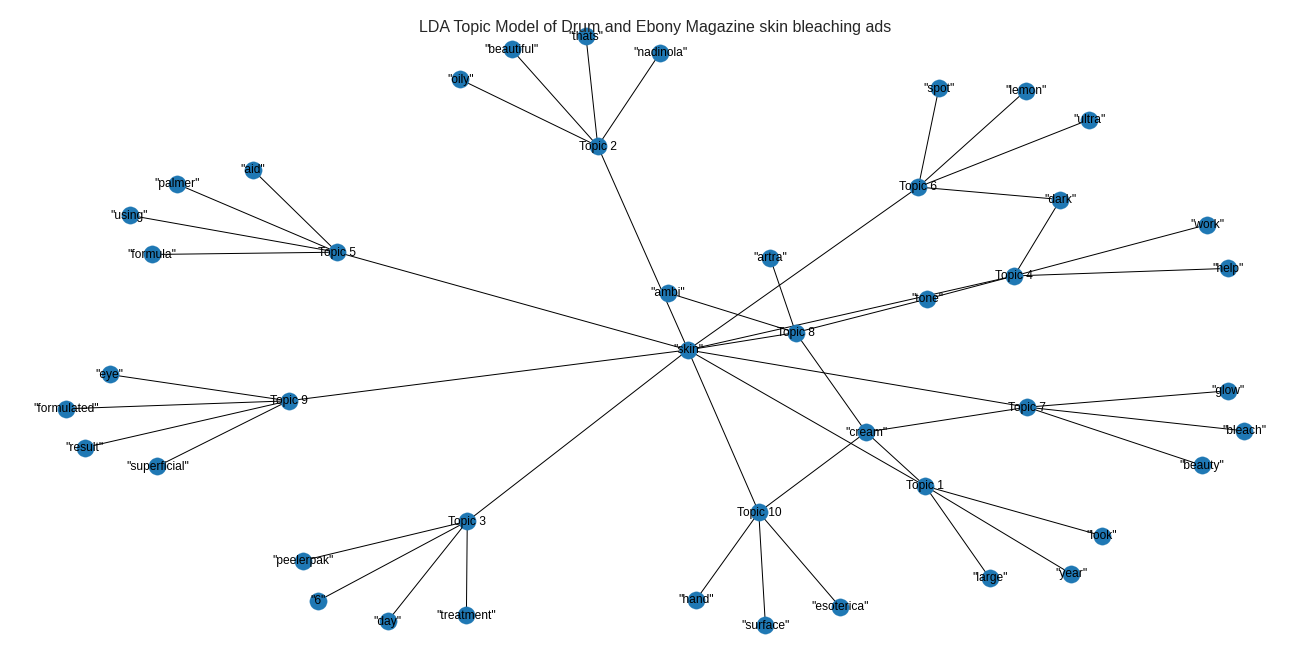

In [146]:
G = nx.Graph()
top_num = 0
for topics in both_topic_list:
    top_num += 1
    G.add_node("Topic "+str(top_num))
    for topic in topics:
        G.add_node(topic[1])
        G.add_edge("Topic "+str(top_num), topic[1])
plt.figure(figsize=(18,9))
plt.suptitle("LDA Topic Model of Drum and Ebony Magazine skin bleaching ads", fontsize=16)
nx.draw(G, with_labels=True)
plt.savefig("./drum_ebony_LDA_network.png")

## Locating Specific Ads

Drum: 
1. "laboratory proven for effectiveness and safe use on normal skin so soothing and refreshing too artras"
2. "'ugly', 'spots', 'and', 'pimples'"
3. "beautiful bride forthat want a lighter sa beautiful bride for people that want a lighter"
4. "give you the smooth clear lighter skin youve notices successful people have hilite lightens and smooths skin"
5. "whitens', 'your', 'skin', 'now'"
6. "more every day american scientist made artralightens and good things happen to a pretty girl brightens skin lightens fr"
7. "smoother protects your skin against harsh sunlight successful people use ambi worried by little pimples and spotskar"
8. "by little pimples and spotskarroo takes these away too successful people use ambi keep my complexion looking light clear"
9. "n give you the smooth clear lighter skin youve notices successful people have karroo morning karoo night makes you"
10. "of your skin you too can look as lovely as a beautiful bride you will be more attractive more desirable will admire"

In [147]:
drum.head()

,Product name,chemical/active ingredient,Claims,Legal issues and Politics,Race,Age,Advertising strategy *quotes-catch phrase*,Size of Advert,Pg. reference ( marked),Notes
Year,,,,,,,,,,
1965-01-01,ARTRA skin tone cream,Hydroquinone,…to make their skin lighter and lovelier…lovel...,Black model and white pharmacist/doctor,Black,20+,"Lighter, lovelier skin today…the American way!'",full pg.,pg. 2,The ad says that the cream was developed after...
1965-01-01,NaN,NaN,brightens skin.' '…lightens from the first day...,n/a,NaN,NaN,Cream your skin lighter and brighter with ama...,NaN,pg. 2,Ad states that it is a medicated beauty bar. S...
1965-01-01,NaN,NaN,immediately.' '…keeps skin beautiful and clean...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1965-01-01,Artra beauty bar,Hydroquinone,…mild and gentle…keeps skin free from blemishe...,NaN,NaN,20+,Medicated soap for complexion care,NaN,NaN,NaN
1965-01-01,Aloma Crème blanche,unnamed,"…clears and lightens the skin, smooth's away b...",Black model,Black,20-35,good things happen to a pretty girl,full pg.,NaN,Ad states that using this product will increas...


In [148]:
catch_phrase_drum.head()

Year
1965-01-01      Lighter, lovelier skin today…the American way!'
1965-01-01     Cream your skin lighter and brighter with ama...
1965-01-01                   Medicated soap for complexion care
1965-01-01                  good things happen to a pretty girl
1965-01-01                                            See notes
Name: Advertising strategy *quotes-catch phrase*, dtype: object

In [149]:
claims_drum.head()

Year
1965-01-01    …to make their skin lighter and lovelier…lovel...
1965-01-01    brightens skin.' '…lightens from the first day...
1965-01-01    immediately.' '…keeps skin beautiful and clean...
1965-01-01    …mild and gentle…keeps skin free from blemishe...
1965-01-01    …clears and lightens the skin, smooth's away b...
Name: Claims, dtype: object

In [150]:
for claim in range(len(drum['Claims'].dropna().str.contains('success'))):
    if type(drum['Claims'][claim]) == float:
        continue
    if 'success' in drum['Claims'][claim]:
        print(drum.index[claim],drum['Claims'][claim])
    

1965-07-19 00:00:00 …lighter, clearer complexion with Ambi…' 'Ambi can give you the smooth, clear, lighter skin you've notices successful people have.'
1966-08-01 00:00:00 …lighter, clearer complexion with Ambi…' 'Ambi can give you the smooth, clear, lighter skin you've notices successful people have.'
1966-09-19 00:00:00 …lighter, clearer complexion with Ambi…' 'Ambi can give you the smooth, clear, lighter skin you've notices successful people have.'
1966-10-01 00:00:00 …lighter, clearer complexion with Ambi…' 'Ambi can give you the smooth, clear, lighter skin you've notices successful people have.'
1966-11-01 00:00:00 …lovey, light complexion' '…success comes from regular Karroo cream care
1967-01-01 00:00:00 …lighter, clearer complexion with Ambi…' 'Ambi can give you the smooth, clear, lighter skin you've notices successful people have.'
1967-03-01 00:00:00 …lighter, clearer complexion with Ambi…' 'Ambi can give you the smooth, clear, lighter skin you've notices successful people ha

In [151]:
drum.loc['1971-08-01']['Claims']

Year
1971-08-01                      stop ugly spots and blemishes' 
1971-08-01                                                  NaN
1971-08-01    the most powerful name in skin lightening crea...
1971-08-01    acting skin lightening cream' 'Hollywood Seven...
1971-08-01    lightens, smooth's and clears skin' "super-sun...
1971-08-01                                  fast and effective'
1971-08-01    …improved ARTRA skin cream…with latest modern ...
1971-08-01    ;works safely to make you lighter, brighter an...
1971-08-01                                                  NaN
1971-08-01    contains fast acting Ambi ingredients to light...
1971-08-01    burning rays of the sun' 'makes you lighter an...
1971-08-01    lightens, smooth's and clears skin ' "super-su...
1971-08-01                                                  NaN
1971-08-01    lightens skin overnight safely' 'during the ni...
1971-08-01    …safe ingredients goes deep into skin & cleans...
1971-08-01                         

In [152]:
try:
    for i in range(len(drum.Claims)):
        if 'skin' in drum.Claims[i]:
            print(drum.Claims[i])
            print(drum.index[i])
except TypeError:
    pass

…to make their skin lighter and lovelier…lovelier and lighter…a little more every day' '…American scientist made artra…lightens and
1965-01-01 00:00:00
brightens skin.' '…lightens from the first day.' '…vanishes into skin instantly…starts working, starts lightening and brightening your skin
1965-01-01 00:00:00
immediately.' '…keeps skin beautiful and clean, makes it smooth and lovely
1965-01-01 00:00:00
…mild and gentle…keeps skin free from blemishes and pimples
1965-01-01 00:00:00
…clears and lightens the skin, smooth's away blemishes and spots, softens the skin'
1965-01-01 00:00:00


In [154]:
# Searching in whole column for term

try:
    for i in range(len(drum.Claims)):
        if drum.Claims is str:
            if "bride" in drum.Claims[i]:

            # indx will store the tuple having that 
            # particular value in column.
                indx = i
        # below line will print that tuple
        drum.iloc[indx]
except NameError:
    print("Not found.")

Not found.


In [155]:
ebony.head()

,Region,Source,Product name,chemical/active ingredient,Structure,Chemistry,Claims,Legal issues and Politics,Race,Age,Advertising strategy *quotes-catch phrase*,Size of Advert,Pg reference (quentin marked),Notes
Year,,,,,,,,,,,,,,
1960-01-01,NaN,Ebony,Long Aid Bleach and Glow,unnamed,NaN,NaN,""" - wakes up dark, dull complexion! Conceals u...",NaN,NaN,NaN,NaN,1/2 pg,63,small part of 1.2 pg ad for Long Aid hair prod...
1960-01-01,NaN,NaN,Mercolized Wax Cream,ammoniated mercury; zinc oxide,NaN,NaN,"""If your skin doesn't look actually lighter af...",NaN,NaN,NaN,"""Mercolized Wax Cream guarantees lighter looki...",1/4 pg,72,ingredient on image of product; not mentioned ...
1960-01-01,NaN,NaN,Black and White Bleaching Cream,unnamed,NaN,NaN,"""And you, too, can have a glamorous complexion...",NaN,NaN,NaN,"""Lighter, brighter skin is irresistable""",1/8 pg,83,drawing of white man and white woman in ad
1960-01-01,NaN,NaN,Nadinola Bleaching Cream,"""wonder-working A-M""",NaN,NaN,"""Don't let dull, dark skin rob you of romance....",NaN,NaN,NaN,"""LIFE IS MORE FUN when your complexion is clea...",full pg,91,two types advertised - oily and dry skin
1960-01-01,NaN,NaN,Dr. Fred Palmer's Double Strength Skin Whitener,zinc phenolsulfonate,NaN,NaN,"""Yes in just 7 days be delighted how fast and ...",NaN,NaN,NaN,"""DR. FRED PALMER'S IN JUST 7 DAYS MUST GIVE YO...",1/8 pg,108,NaN
